# Mini Project: Tree-Based Algorithms

## The "German Credit" Dataset

### Dataset Details

This dataset has two classes (these would be considered labels in Machine Learning terms) to describe the worthiness of a personal loan: "Good" or "Bad". There are predictors related to attributes, such as: checking account status, duration, credit history, purpose of the loan, amount of the loan, savings accounts or bonds, employment duration, installment rate in percentage of disposable income, personal information, other debtors/guarantors, residence duration, property, age, other installment plans, housing, number of existing credits, job information, number of people being liable to provide maintenance for, telephone, and foreign worker status.

Many of these predictors are discrete and have been expanded into several 0/1 indicator variables (a.k.a. they have been one-hot-encoded).

This dataset has been kindly provided by Professor Dr. Hans Hofmann of the University of Hamburg, and can also be found on the UCI Machine Learning Repository.

In [203]:
import graphviz
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from dtreeviz import trees
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
from sklearn.metrics import matthews_corrcoef
sns.set(rc={'figure.figsize':(20,18)})

In [2]:
accuracy_scores = {}

In [3]:
german_credit = pd.read_csv("GermanCredit.csv.zip", compression="zip")

In [4]:
good_bad = {'Bad': 0,'Good':1}

In [5]:
german_credit.Class = german_credit.Class.apply(lambda x: good_bad[x])
# y = ytrain.apply(lambda x: good_bad[x])
# y_test = ytest.apply(lambda x: good_bad[x])

In [6]:
cls = german_credit.Class
features = german_credit.loc[:, german_credit.columns[german_credit.columns != 'Class']]

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, cls, train_size=0.7, test_size=0.3, random_state=24)

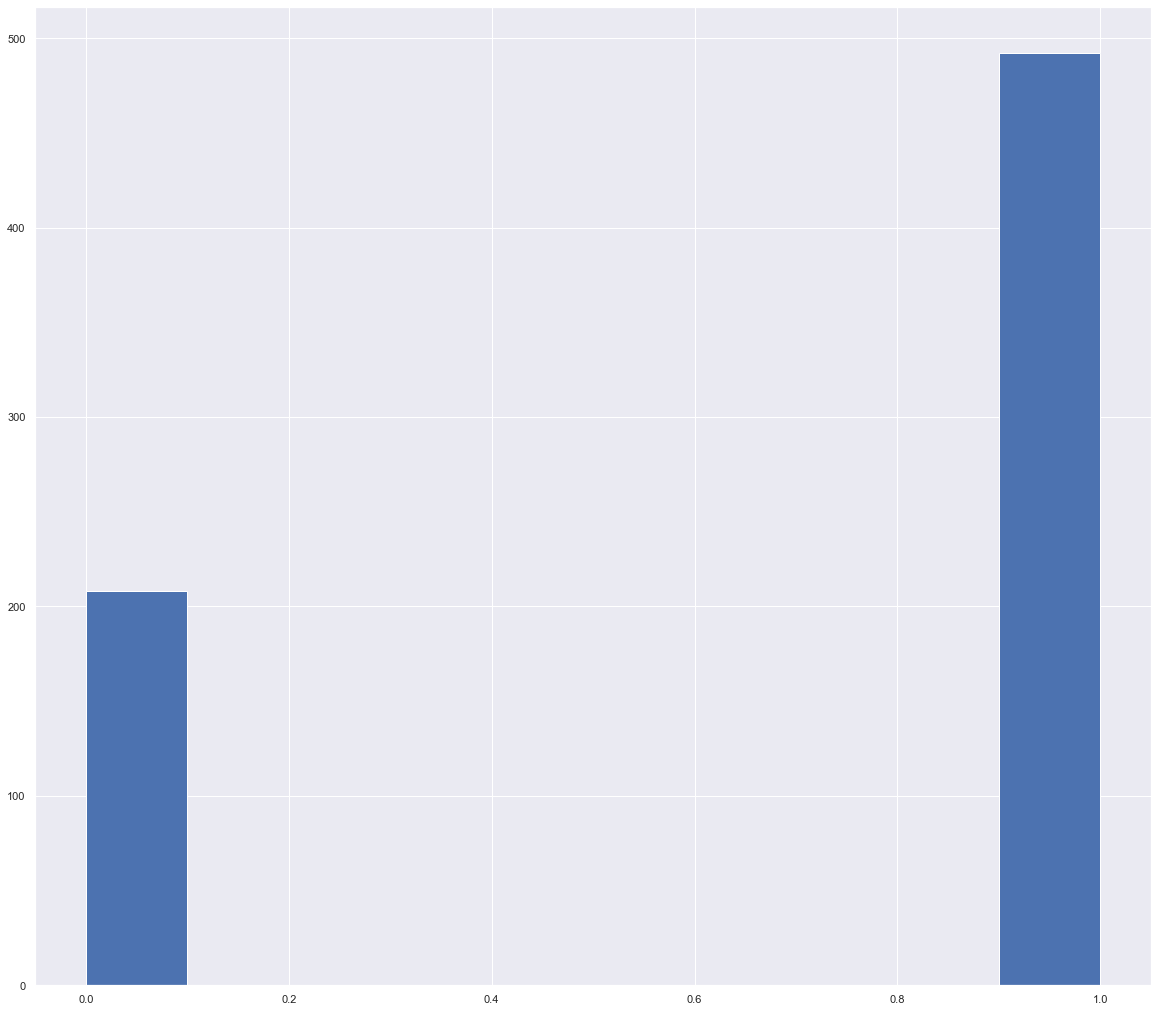

In [8]:
ytrain.hist()

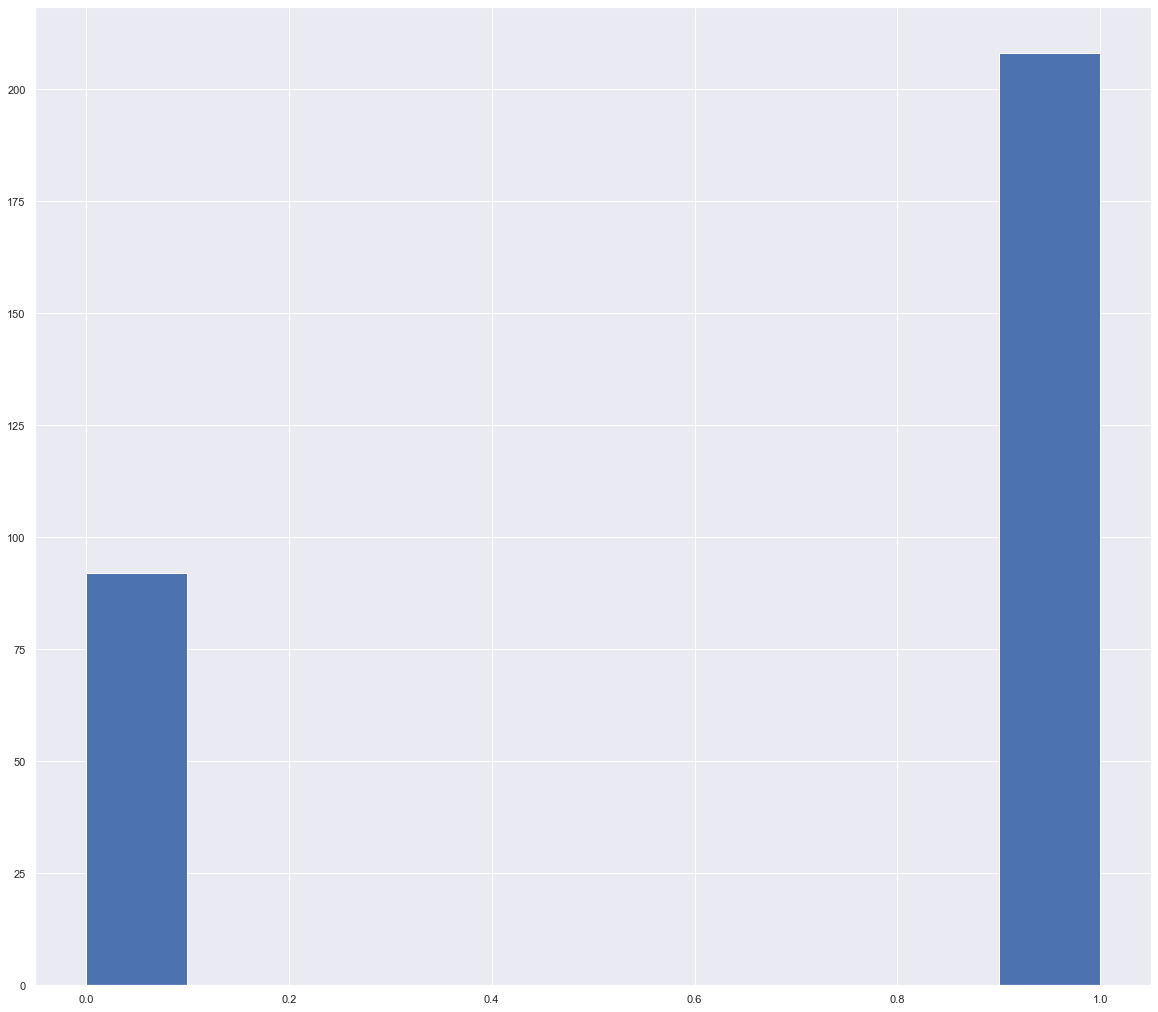

In [9]:
ytest.hist()

## We have a class distribution issue that we need to address at some point. For now we won't perform an sampling techniques to address this

## Create and evaluate a baseline decision tree here without any feature engineering

In [10]:
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain, ytrain)
results = clf.predict(Xtest)

In [11]:
accuracy_scores["DescionTreeClassifier"] = accuracy_score(results, ytest)
print(classification_report(results, ytest))

              precision    recall  f1-score   support

           0       0.51      0.55      0.53        86
           1       0.81      0.79      0.80       214

    accuracy                           0.72       300
   macro avg       0.66      0.67      0.66       300
weighted avg       0.73      0.72      0.72       300



In [12]:
print(confusion_matrix(results, ytest))

[[ 47  39]
 [ 45 169]]


|True Negative|False Negative|False Postive|True Positive|
|---|---|---|---|
|47|45|41|167|


#### Specificity
> 0.534 = 47 / (47 + 41)

#### Sensitivity
> 0.788 = 47 / (47 + 41)

In [13]:
zipped = dict(zip(Xtrain.columns,clf.feature_importances_))
feature_importance = pd.DataFrame(zipped, index=[0]) *100

Text(0, 0.5, 'True Positive Rate')

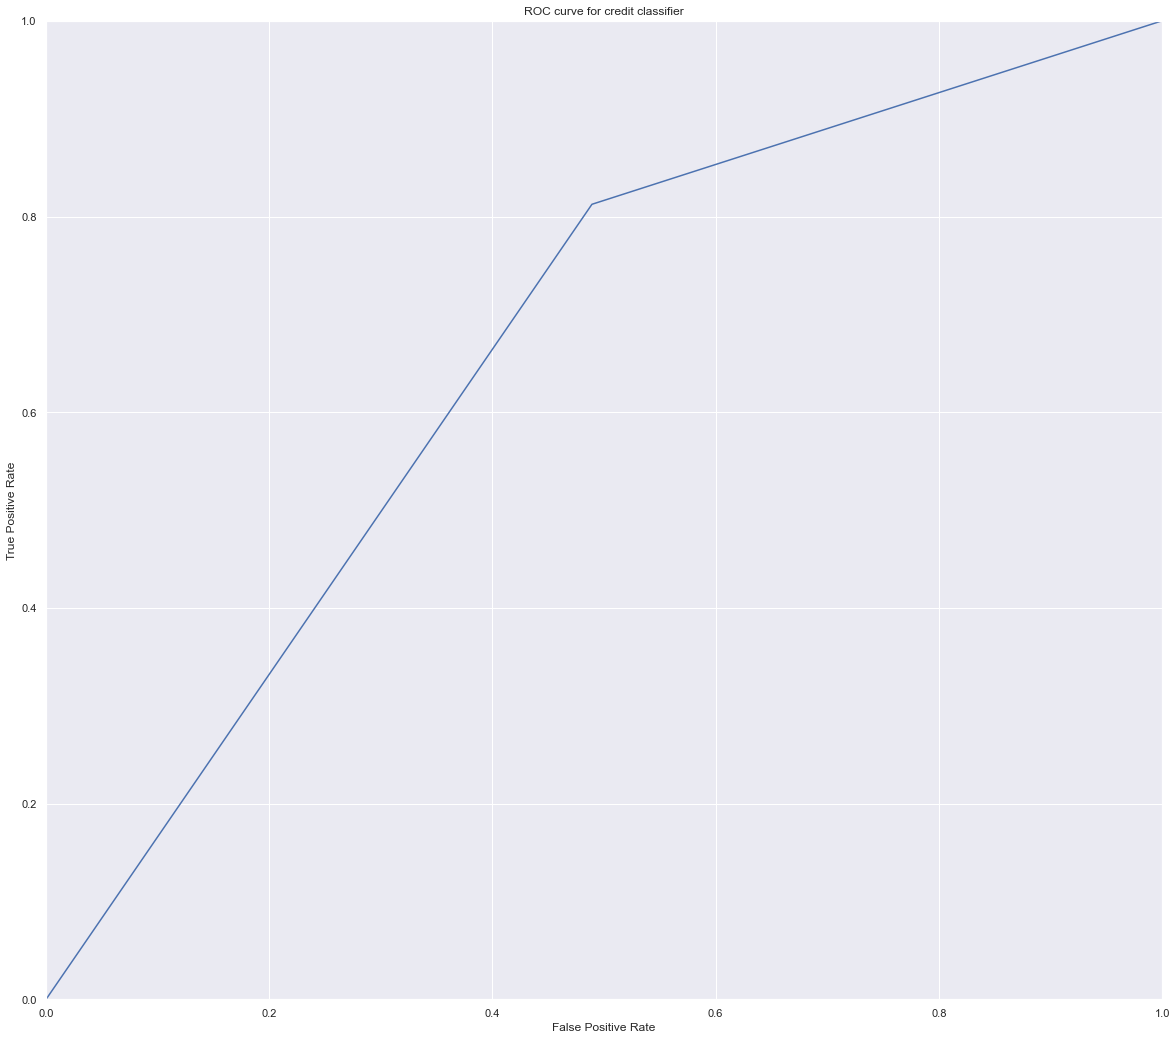

In [14]:
fpr, tpr, thresholds = roc_curve(y_true=ytest, y_score=clf.predict_proba(Xtest)[:,1])
plt.plot(fpr, tpr)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("ROC curve for credit classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Here is the confusion matrix from above
|True Negatives   | False Negatives   | False Positives   | True Positives  |
|---------------- | ----------------- | ----------------- | ----------------|
|47|45|41|167|

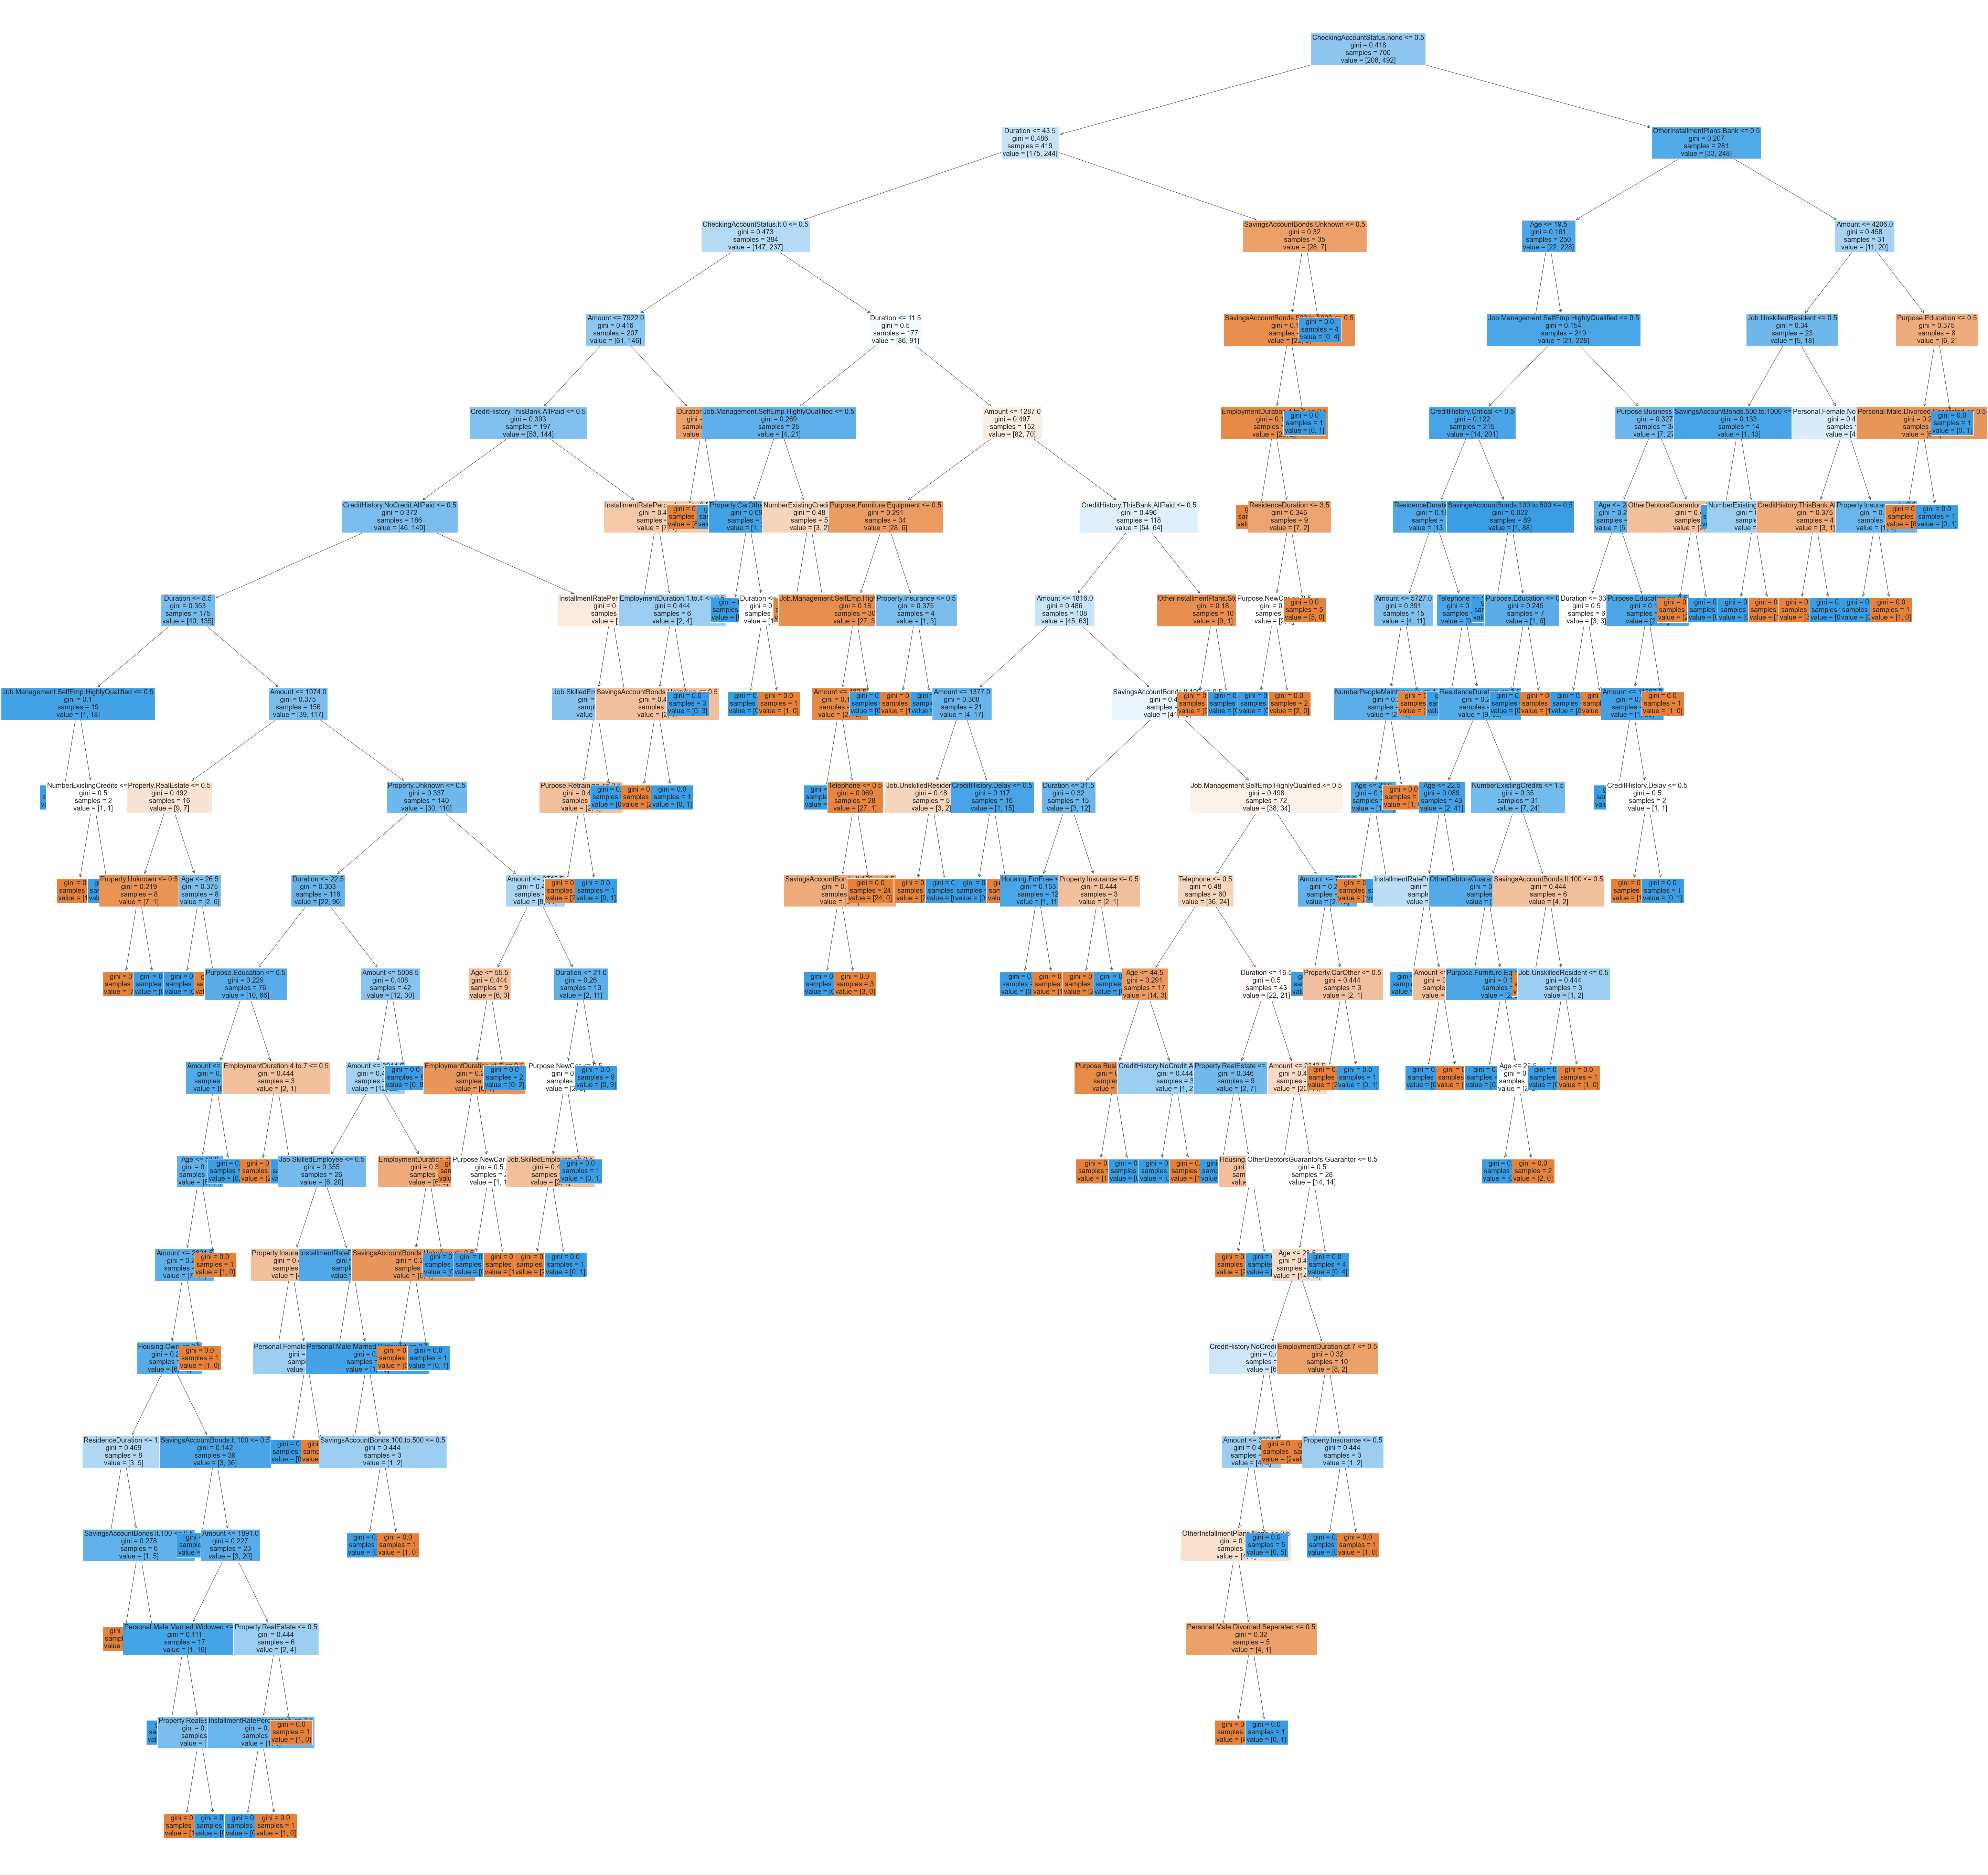

In [15]:
fig = plt.gcf()
fig.set_size_inches(100, 100)
# plt.figure(figsize=(100,30))
tree.plot_tree(clf, feature_names=Xtrain.columns.tolist(), fontsize=20, filled=True);
plt.show()

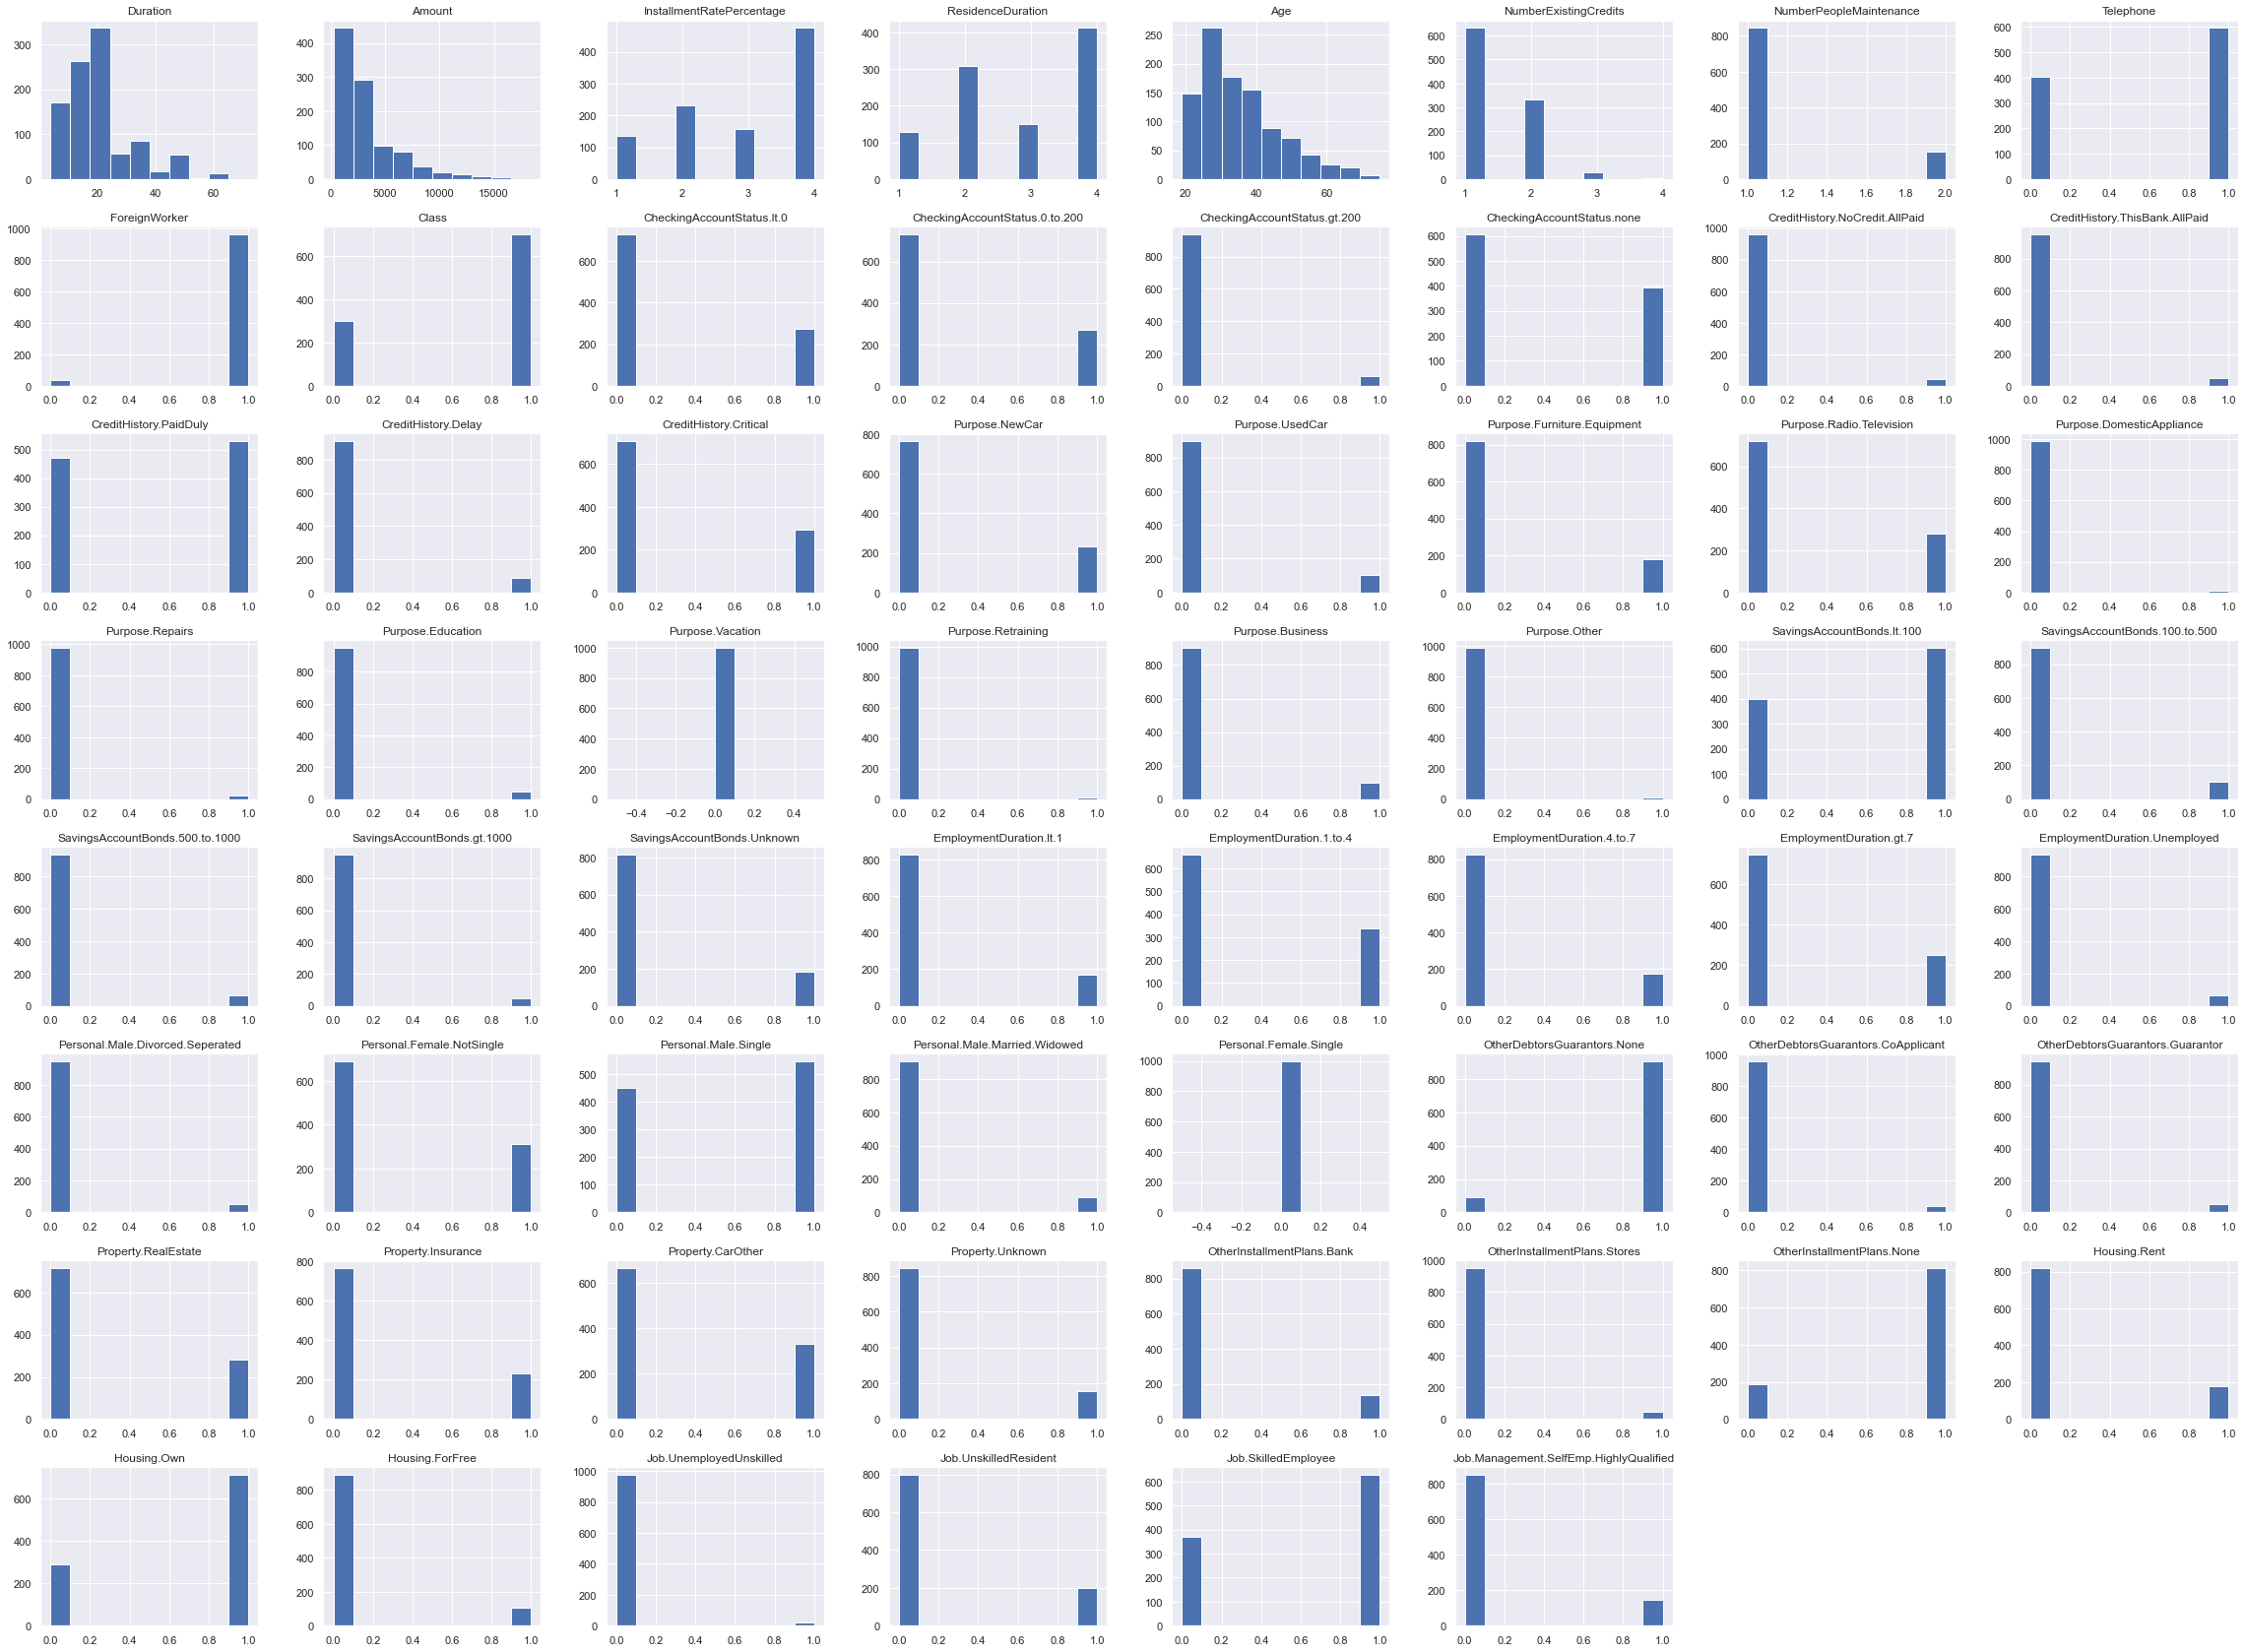

In [16]:
german_credit.hist(figsize=(40,30));

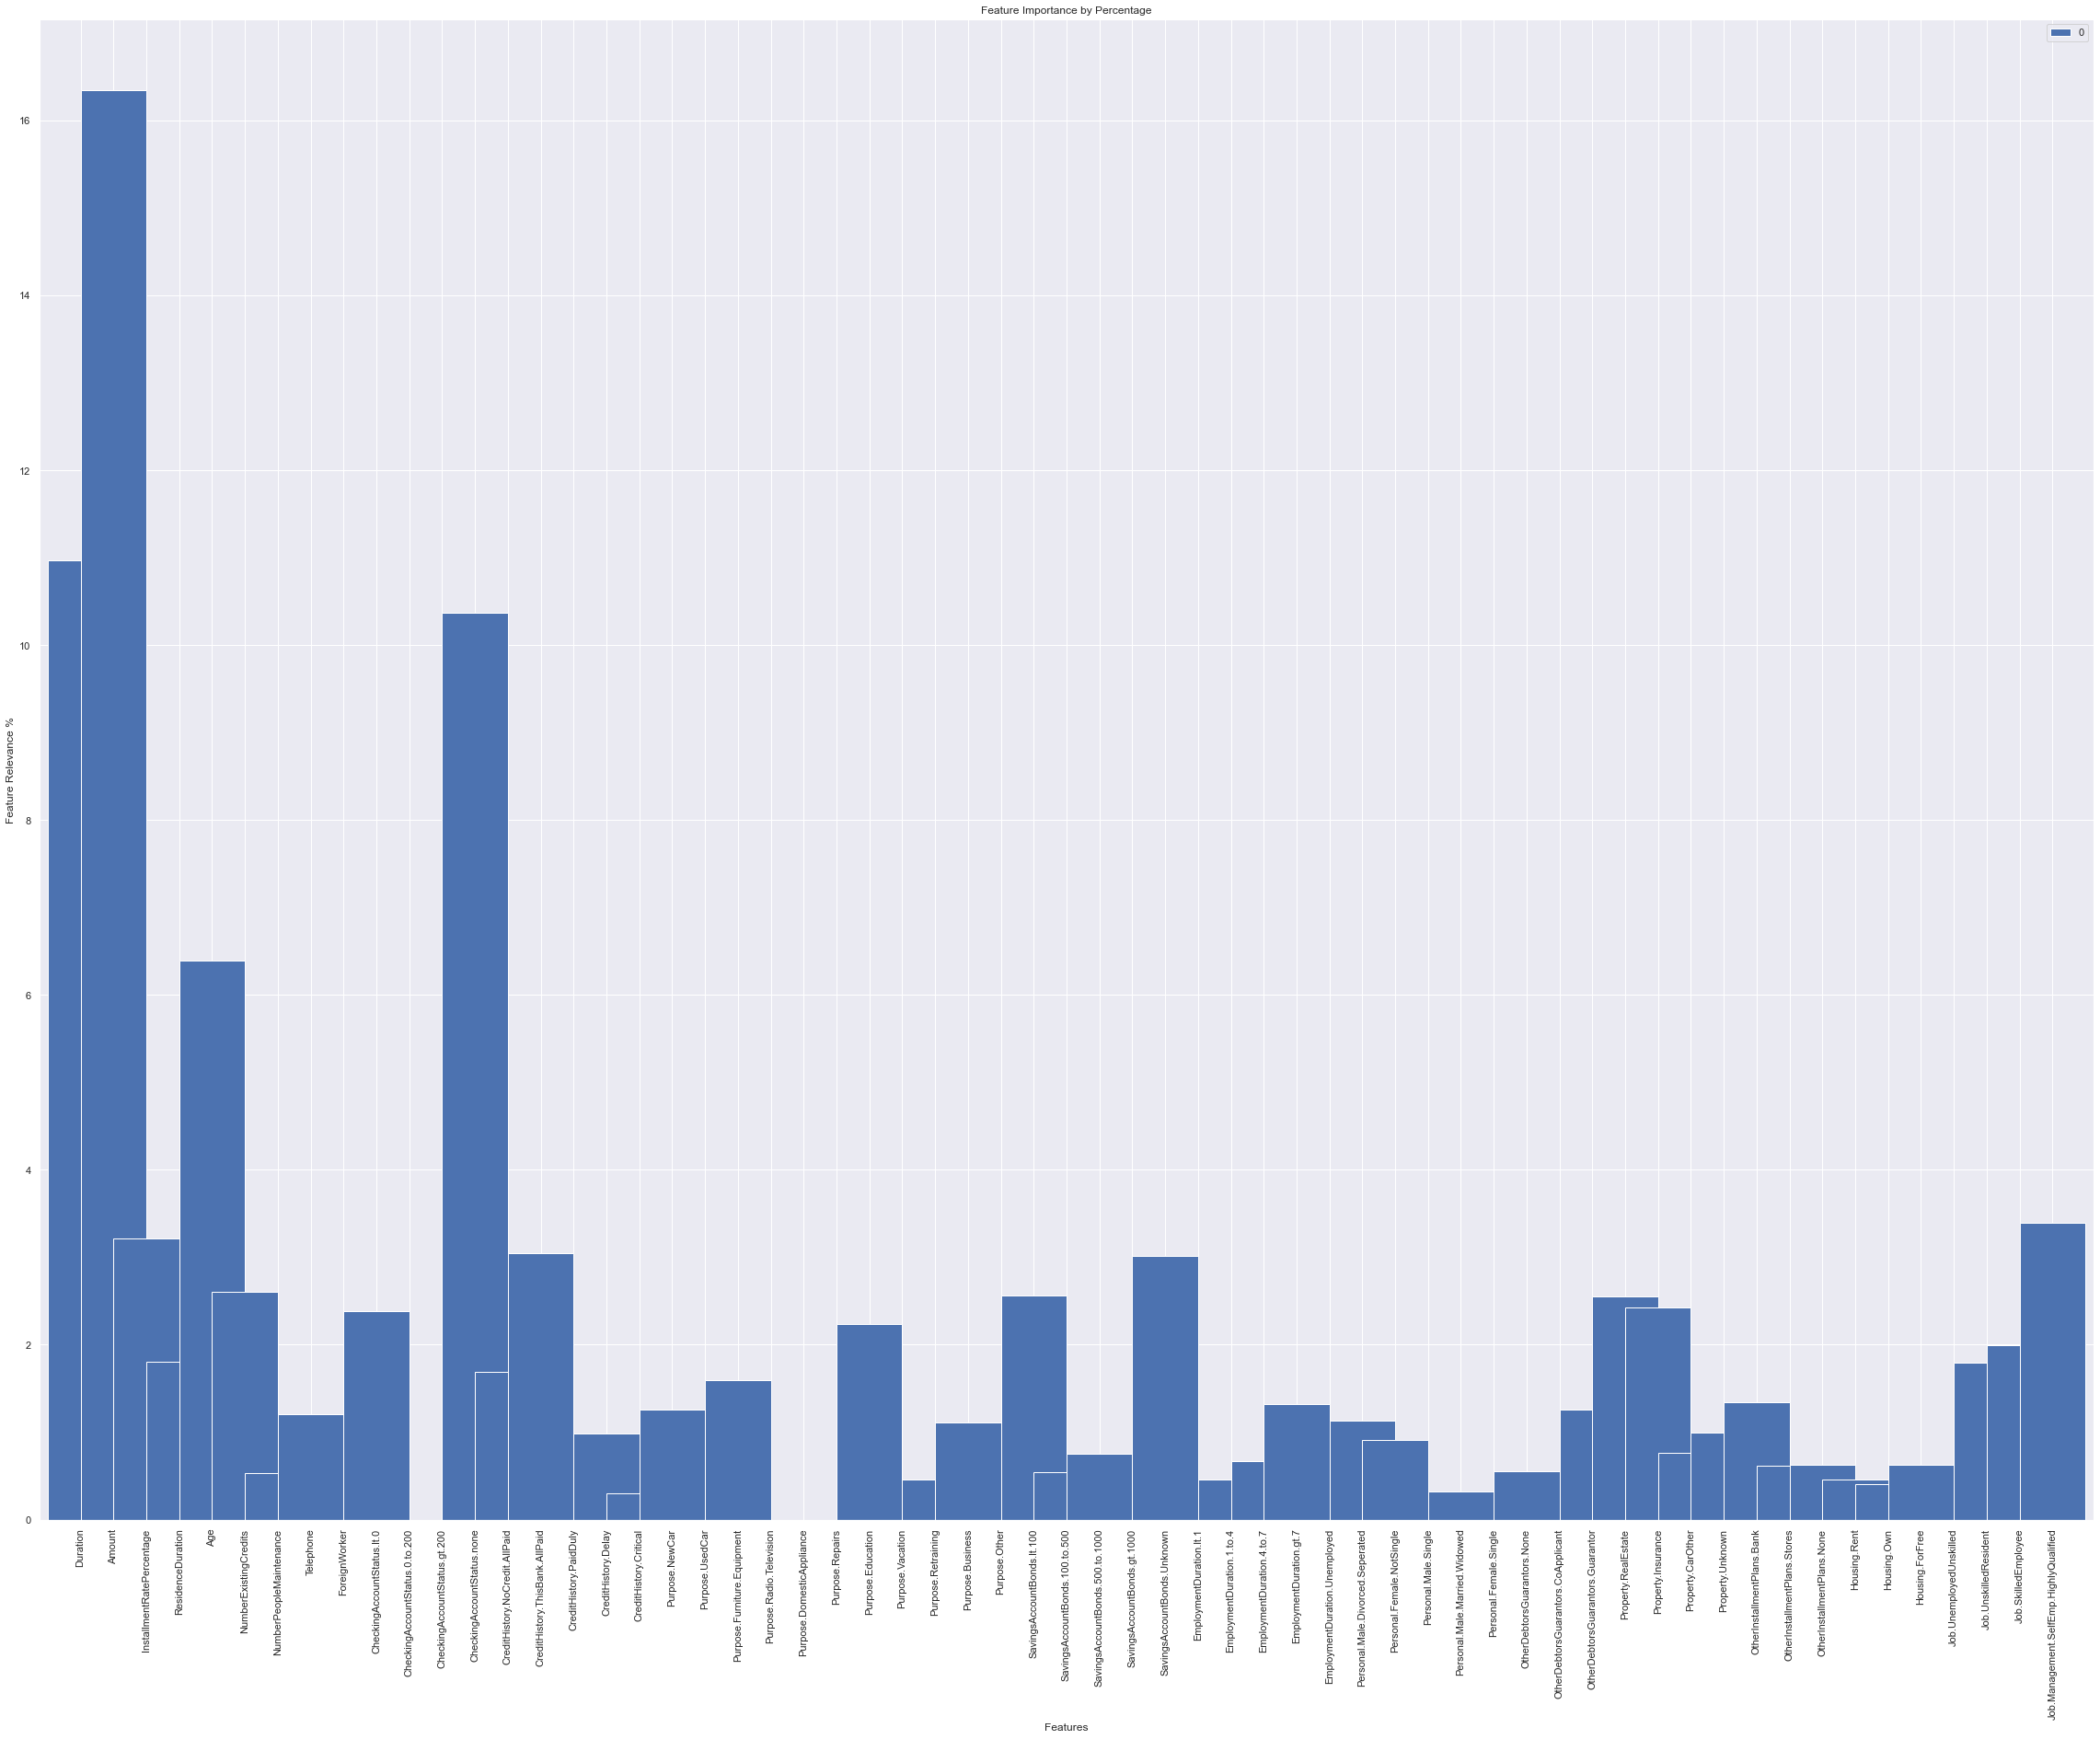

In [17]:
feature_importance.T.plot.bar(figsize=(40,30), width=2);
plt.xlabel("Features");
plt.ylabel("Feature Relevance %");
plt.title("Feature Importance by Percentage");

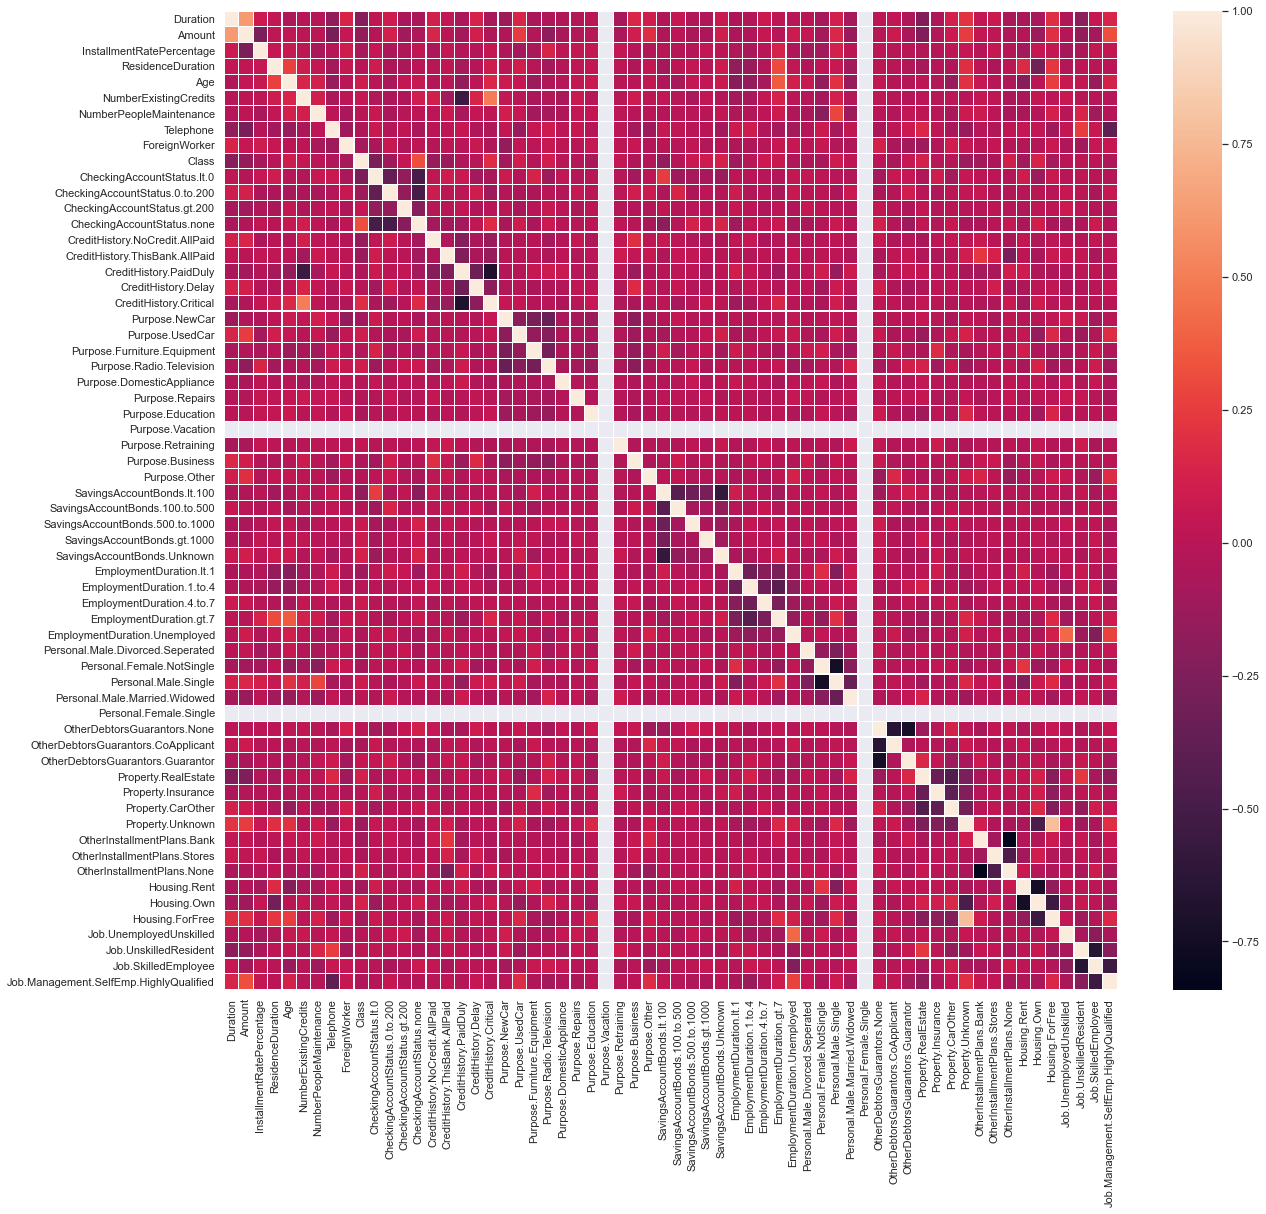

In [18]:
sns.heatmap(german_credit.corr(), linewidths=0.2);

In [19]:
ros = RandomOverSampler(sampling_strategy=0.50, random_state=1)
Xtrain_rs, ytrain_rs = ros.fit_resample(Xtrain, ytrain)


In [20]:
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain_rs, ytrain_rs)
results_os = clf.predict(Xtest)

In [21]:
print(classification_report(results_os, ytest))

print(confusion_matrix(results_os, ytest))

              precision    recall  f1-score   support

           0       0.42      0.48      0.45        81
           1       0.80      0.76      0.78       219

    accuracy                           0.68       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.70      0.68      0.69       300

[[ 39  42]
 [ 53 166]]


In [22]:
ros = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
Xtrain_us, ytrain_us = ros.fit_resample(Xtrain, ytrain)


In [23]:
clf_us = DecisionTreeClassifier()
clf_us = clf_us.fit(Xtrain_us, ytrain_us)
results_us = clf_us.predict(Xtest)

In [24]:
print(classification_report(results_us, ytest))

print(confusion_matrix(results_us, ytest))

              precision    recall  f1-score   support

           0       0.51      0.47      0.49        99
           1       0.75      0.78      0.76       201

    accuracy                           0.68       300
   macro avg       0.63      0.63      0.63       300
weighted avg       0.67      0.68      0.67       300

[[ 47  52]
 [ 45 156]]


### After you've built the best model you can, now it's time to visualize it!

Rememeber that amazing blog post from a few paragraphs ago, that demonstrated how to visualize and interpret the results of your Decision Tree model. We've seen that this can perform very well, but let's see how it does on the "German Credit" dataset that we're working on, due to it being a bit larger than the one used by the blog authors.

First, we're going to need to install their package. If you're using Anaconda, this can be done easily by running:

If for any reason this way of installing doesn't work for you straight out of the box, please refer to the more detailed documentation here: https://github.com/parrt/dtreeviz

Now you're ready to visualize your Decision Tree model! Please feel free to use the blog post for guidance and inspiration!

In [25]:
# Your code here! :)
sk_dtree = ShadowSKDTree(clf, Xtrain_rs, ytrain_rs, Xtrain.columns.tolist(), ytrain_rs.name, [0, 1])

C:\Users\rivverg\Anaconda3\envs\mec-miniprojects\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


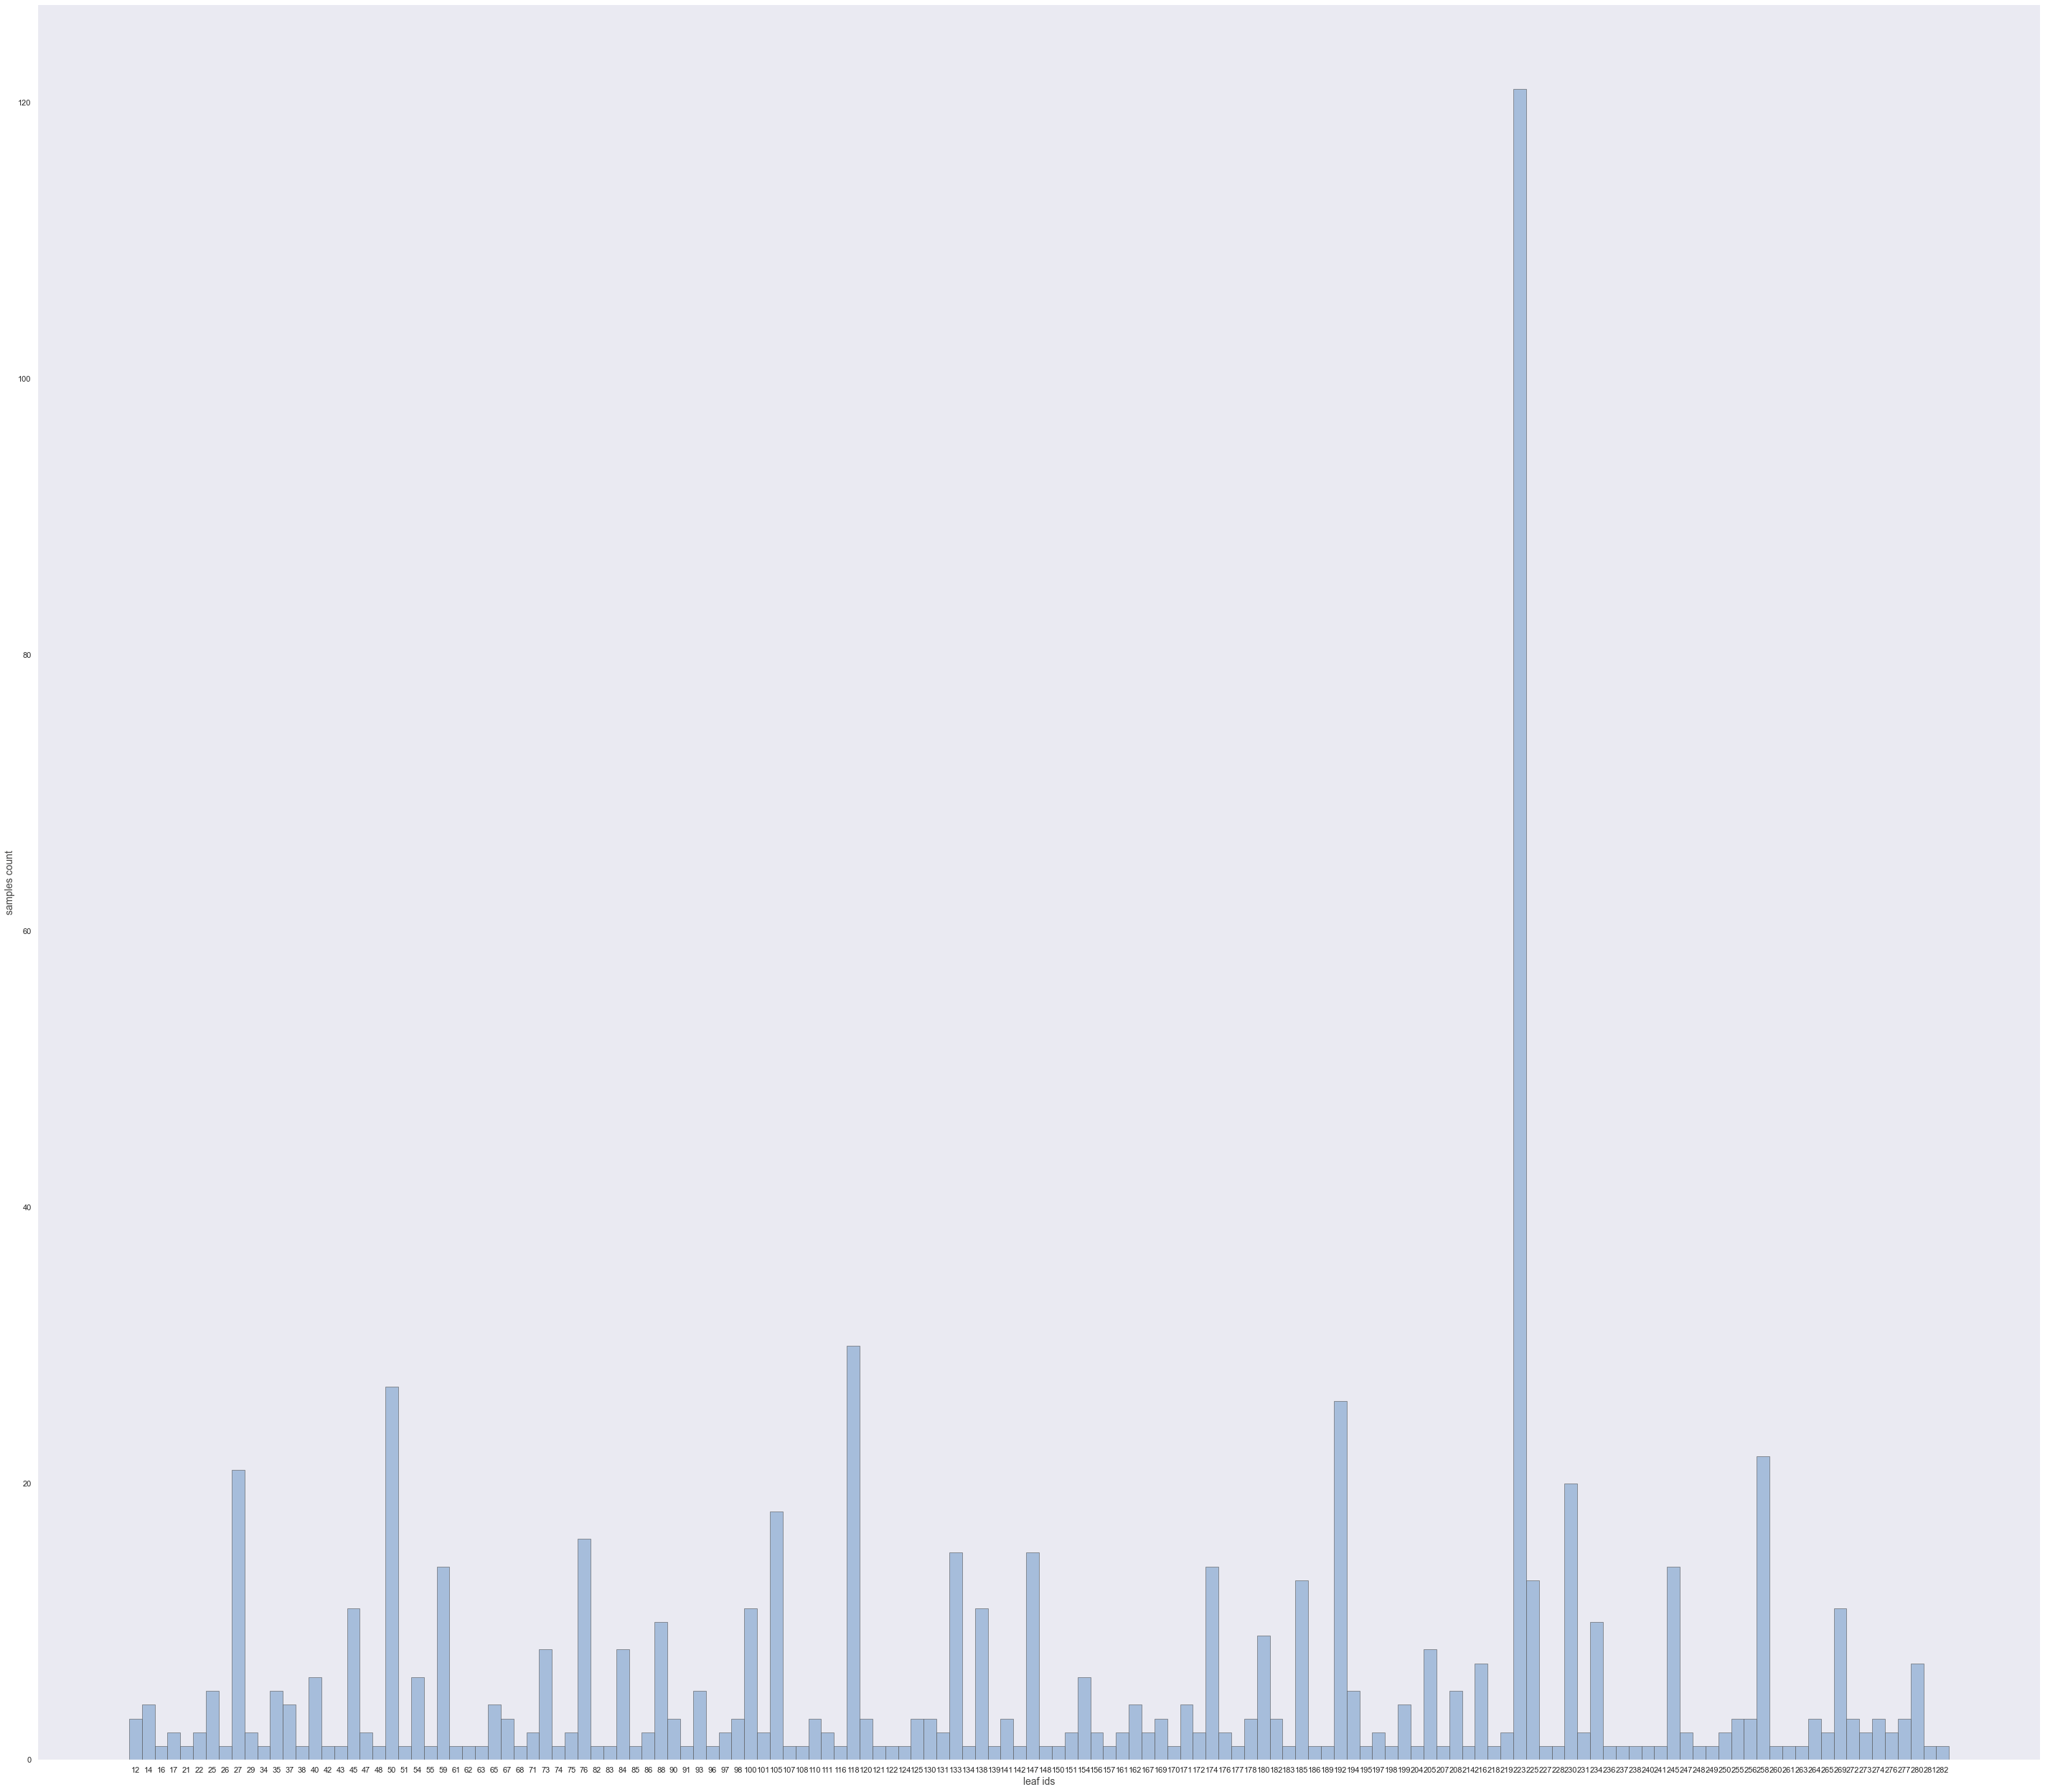

In [26]:
trees.viz_leaf_samples(clf, Xtrain_rs, Xtrain.columns.tolist(), figsize=(50,45))

C:\Users\rivverg\Anaconda3\envs\mec-miniprojects\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


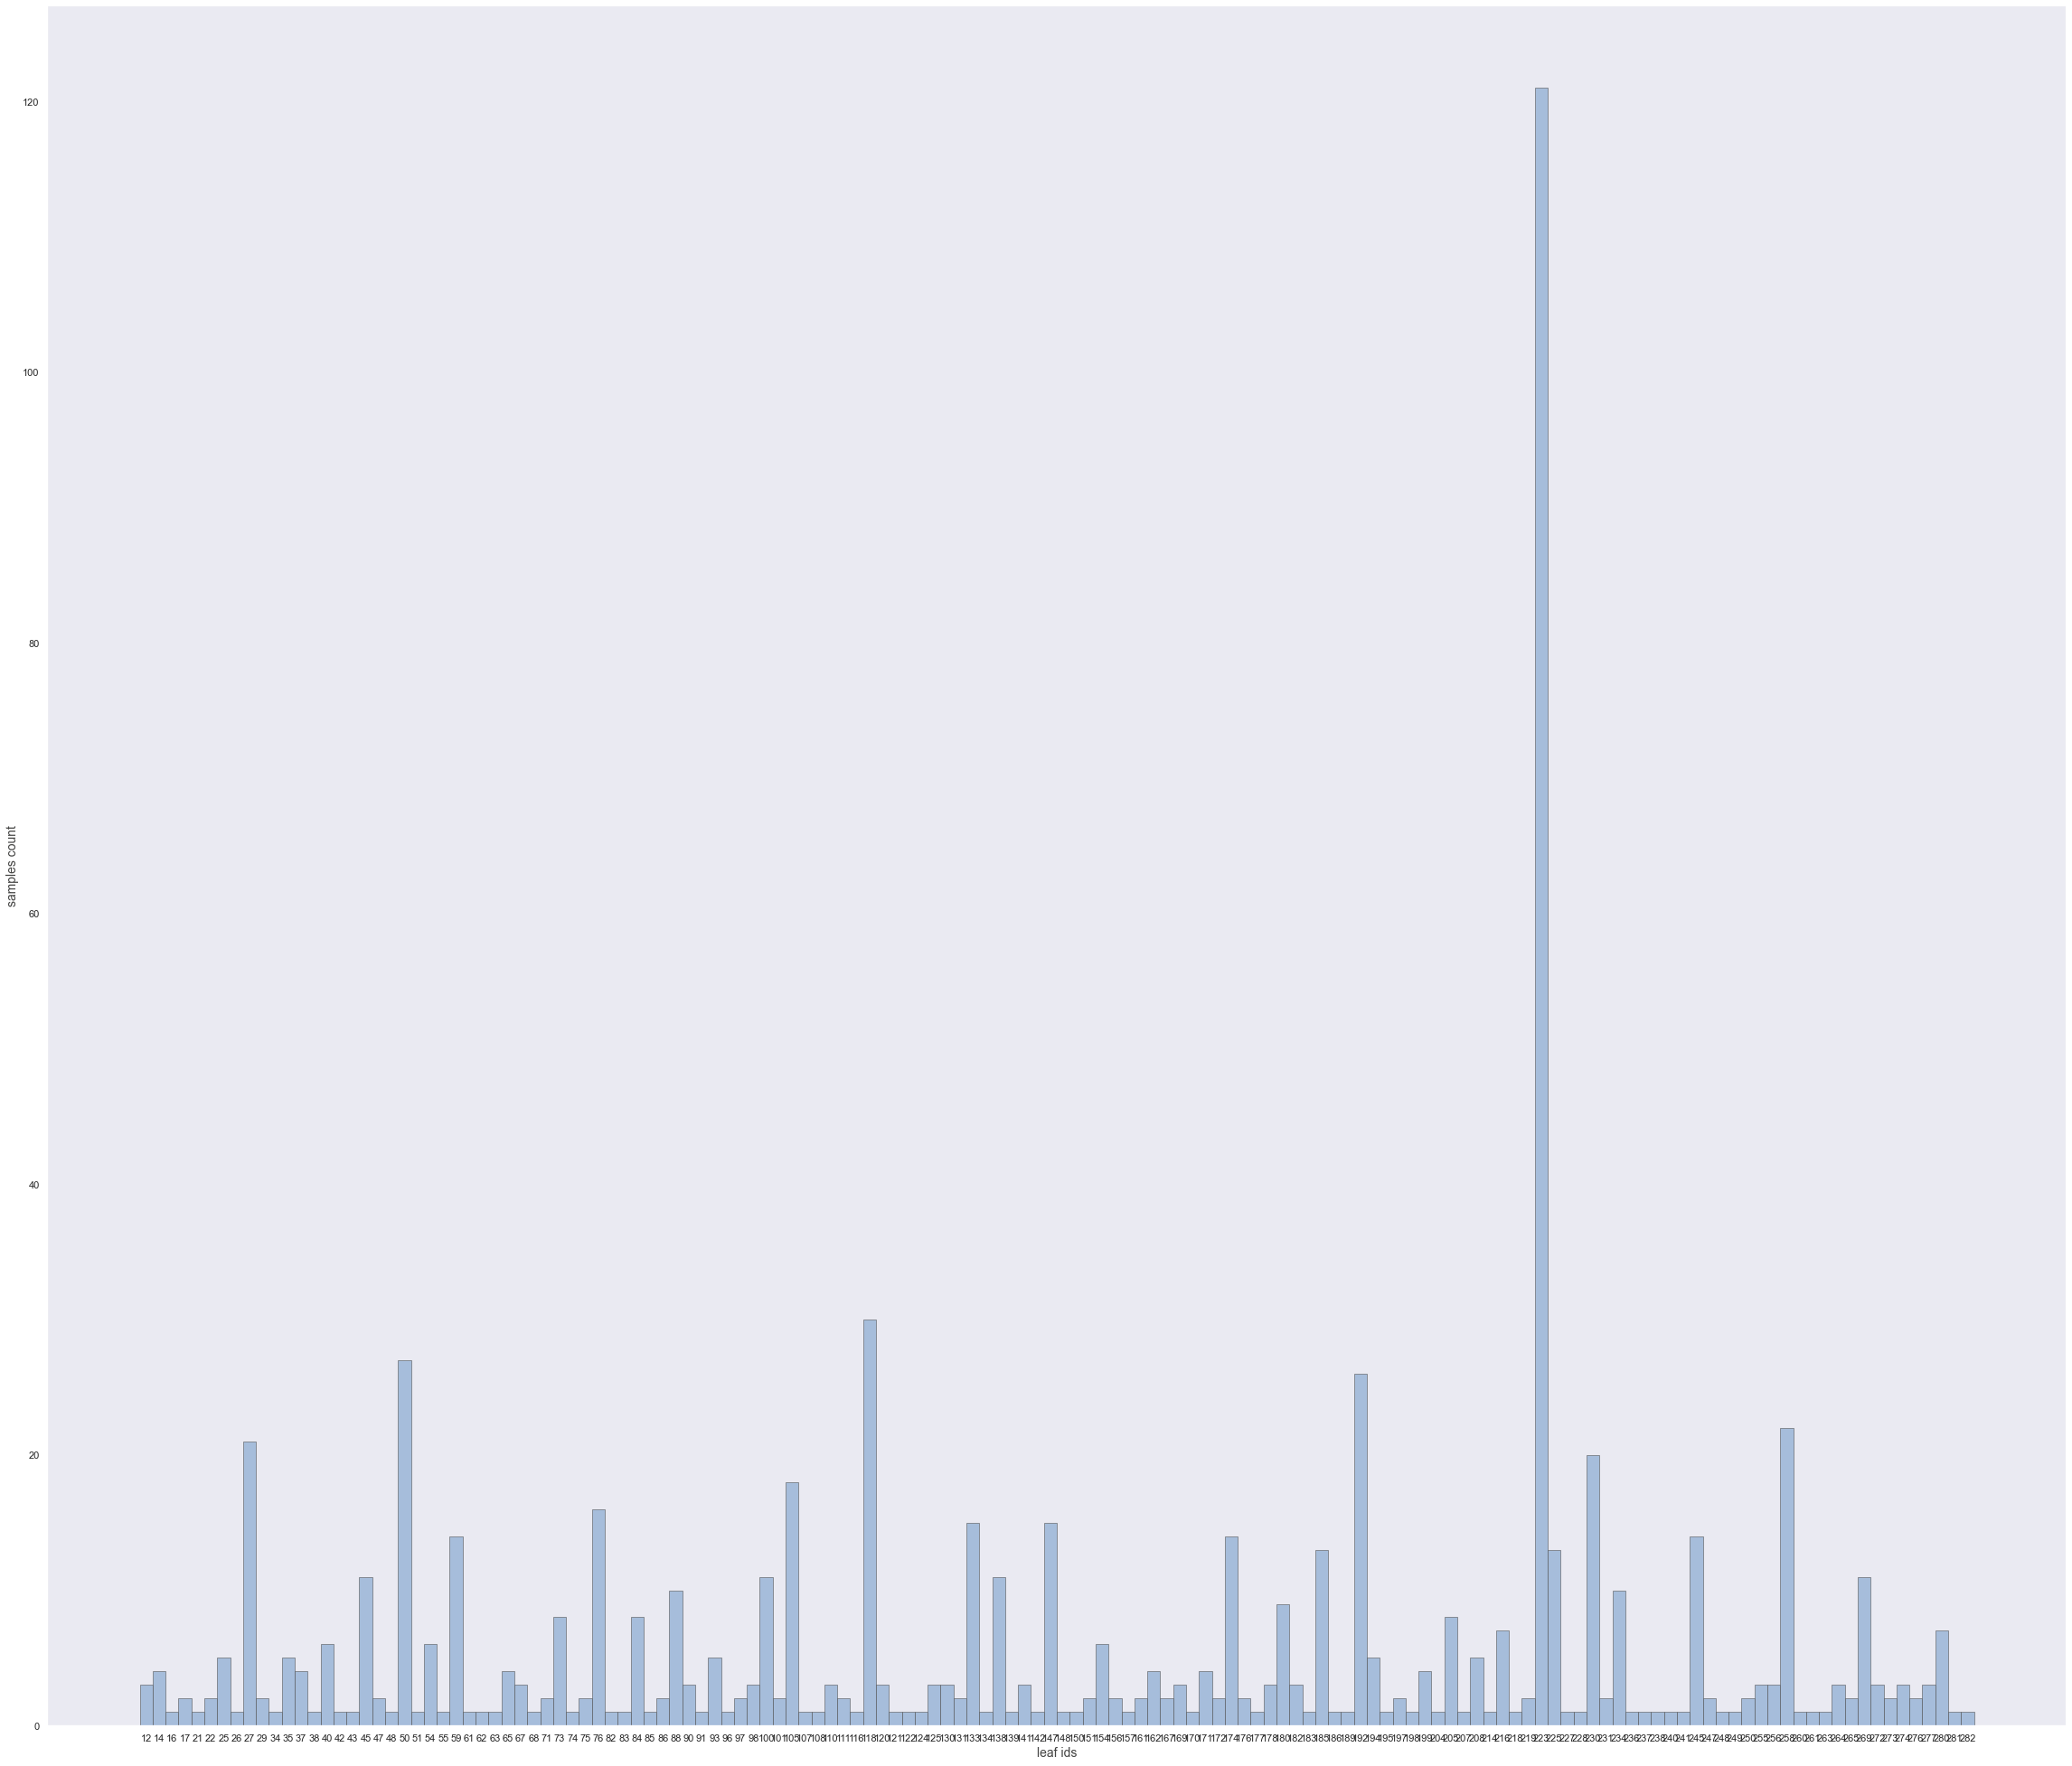

In [27]:
trees.viz_leaf_samples(sk_dtree, figsize=(40,35))



In [28]:
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain, ytrain)
results = clf.predict(Xtest)

In [205]:
print(classification_report(results, ytest))

print(confusion_matrix(results, ytest))

print(f"Mattews correlation coefficient: {matthews_corrcoef(ytest, results)}")

              precision    recall  f1-score   support

           0       0.41      0.63      0.50        60
           1       0.89      0.78      0.83       240

    accuracy                           0.75       300
   macro avg       0.65      0.70      0.67       300
weighted avg       0.80      0.75      0.76       300

[[ 38  22]
 [ 54 186]]
Mattews correlation coefficient: 0.3542178958293221


In [155]:
ros = RandomOverSampler(sampling_strategy=0.50, random_state=1)
Xtrain_rs, ytrain_rs = ros.fit_resample(Xtrain, ytrain)


In [156]:
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain_rs, ytrain_rs)
results_os = clf.predict(Xtest)


In [157]:
print(classification_report(results_os, ytest))

print(confusion_matrix(results_os, ytest))


              precision    recall  f1-score   support

           0       0.46      0.46      0.46        92
           1       0.76      0.76      0.76       208

    accuracy                           0.67       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.67      0.67      0.67       300

[[ 42  50]
 [ 50 158]]


In [31]:
ros = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
Xtrain_us, ytrain_us = ros.fit_resample(Xtrain, ytrain)


clf_us = DecisionTreeClassifier()
clf_us = clf_us.fit(Xtrain_us, ytrain_us)
results_us = clf_us.predict(Xtest)

print(classification_report(results_us, ytest))

print(confusion_matrix(results_us, ytest))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52       101
           1       0.75      0.79      0.77       199

    accuracy                           0.69       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.68      0.69      0.69       300

[[ 50  51]
 [ 42 157]]


## Random Forests

As discussed in the lecture videos, Decision Tree algorithms also have certain undesireable properties. Mainly the have low bias, which is good, but tend to have high variance - which is *not* so good (more about this problem here: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

Noticing these problems, the late Professor Leo Breiman, in 2001, developed the Random Forests algorithm, which mitigates these problems, while at the same time providing even higher predictive accuracy than the majority of Decision Tree algorithm implementations. While the curriculum contains two excellent lectures on Random Forests, if you're interested, you can dive into the original paper here: https://link.springer.com/content/pdf/10.1023%2FA%3A1010933404324.pdf.

In the next part of this assignment, your are going to use the same "German Credit" dataset to train, tune, and measure the performance of a Random Forests model. You will also see certain functionalities that this model, even though it's a bit of a "black box", provides for some degree of interpretability.

First, let's build a Random Forests model, using the same best practices that you've used for your Decision Trees model. You can reuse the things you've already imported there, so no need to do any re-imports, new train/test splits, or loading up the data again.

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rf = RandomForestClassifier()
clf = rf.fit(Xtrain, ytrain)
rf_results = clf.predict(Xtest)

In [34]:
accuracy_scores["RandomTreeClassifier"] = accuracy_score(rf_results, ytest)

print(classification_report(rf_results, ytest))

print(confusion_matrix(rf_results, ytest))

              precision    recall  f1-score   support

           0       0.26      0.52      0.35        46
           1       0.89      0.73      0.81       254

    accuracy                           0.70       300
   macro avg       0.58      0.63      0.58       300
weighted avg       0.80      0.70      0.74       300

[[ 24  22]
 [ 68 186]]


In [35]:
ros = RandomOverSampler(sampling_strategy='not majority', random_state=1)
Xtrain_os, ytrain_os = ros.fit_resample(Xtrain, ytrain)

rf = RandomForestClassifier()
clf = rf.fit(Xtrain_os, ytrain_os)
rf_results = clf.predict(Xtest)

In [206]:
print(classification_report(rf_results, ytest))

print(confusion_matrix(rf_results, ytest))


print(f"Mattews correlation coefficient: {matthews_corrcoef(ytest, rf_results)}")

              precision    recall  f1-score   support

           0       0.42      0.61      0.50        64
           1       0.88      0.78      0.82       236

    accuracy                           0.74       300
   macro avg       0.65      0.69      0.66       300
weighted avg       0.78      0.74      0.76       300

[[ 39  25]
 [ 53 183]]
Mattews correlation coefficient: 0.34186452440221654


As mentioned, there are certain ways to "peek" into a model created by the Random Forests algorithm. The first, and most popular one, is the Feature Importance calculation functionality. This allows the ML practitioner to see an ordering of the importance of the features that have contributed the most to the predictive accuracy of the model. 

You can see how to use this in the scikit-learn documentation (http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_). Now, if you tried this, you would just get an ordered table of not directly interpretable numeric values. Thus, it's much more useful to show the feature importance in a visual way. You can see an example of how that's done here: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

Now you try! Let's visualize the importance of features from your Random Forests model!

In [37]:
zipped = dict(zip(Xtrain.columns,clf.feature_importances_))
feature_importance = pd.DataFrame(zipped, index=[0]) *100

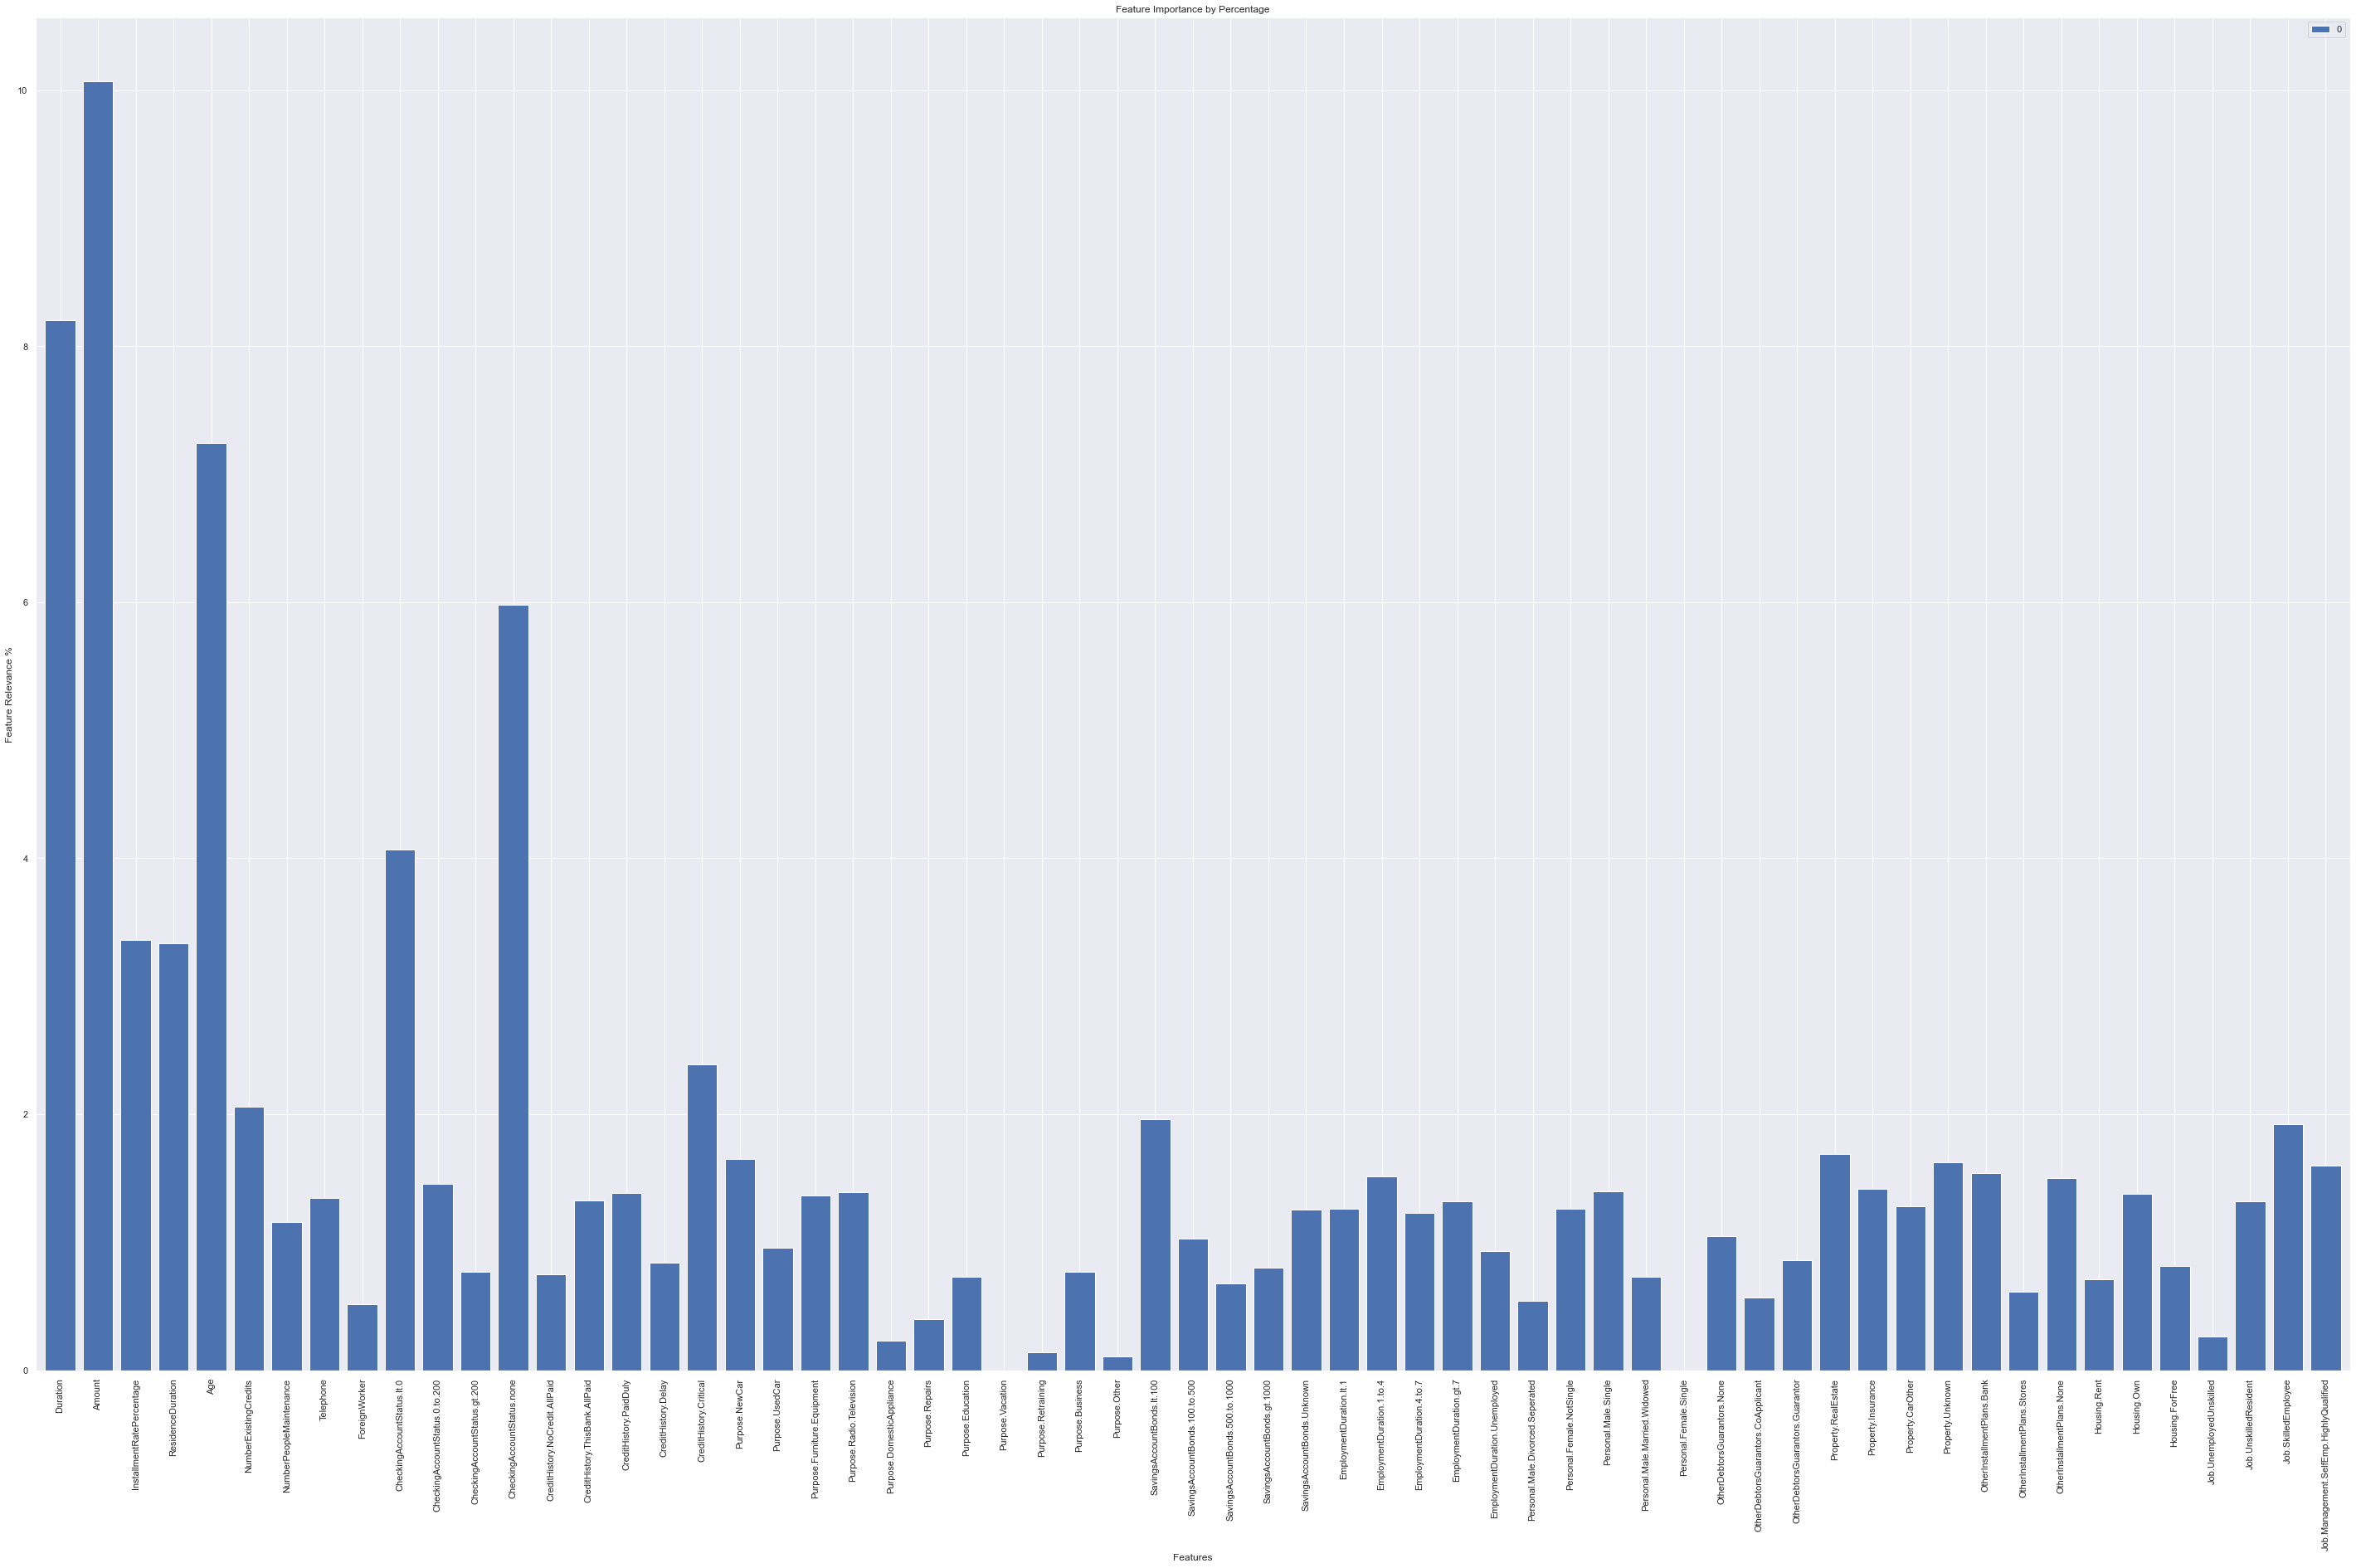

In [38]:
feature_importance.T.plot.bar(figsize=(50,30), width=0.8);
plt.xlabel("Features");
plt.ylabel("Feature Relevance %");
plt.title("Feature Importance by Percentage");

A final method for gaining some insight into the inner working of your Random Forests models is a so-called Partial Dependence Plot. The Partial Dependence Plot (PDP or PD plot) shows the marginal effect of a feature on the predicted outcome of a previously fit model. The prediction function is fixed at a few values of the chosen features and averaged over the other features. A partial dependence plot can show if the relationship between the target and a feature is linear, monotonic or more complex. 

In scikit-learn, PDPs are implemented and available for certain algorithms, but at this point (version 0.20.0) they are not yet implemented for Random Forests. Thankfully, there is an add-on package called **PDPbox** (https://pdpbox.readthedocs.io/en/latest/) which adds this functionality to Random Forests. The package is easy to install through pip.

While we encourage you to read the documentation for the package (and reading package documentation in general is a good habit to develop), the authors of the package have also written an excellent blog post on how to use it, showing examples on different algorithms from scikit-learn (the Random Forests example is towards the end of the blog post): https://briangriner.github.io/Partial_Dependence_Plots_presentation-BrianGriner-PrincetonPublicLibrary-4.14.18-updated-4.22.18.html

So, armed with this new knowledge, feel free to pick a few features, and make a couple of Partial Dependence Plots of your own!

In [39]:
# Your code here!
from pdpbox import pdp, get_dataset, info_plots



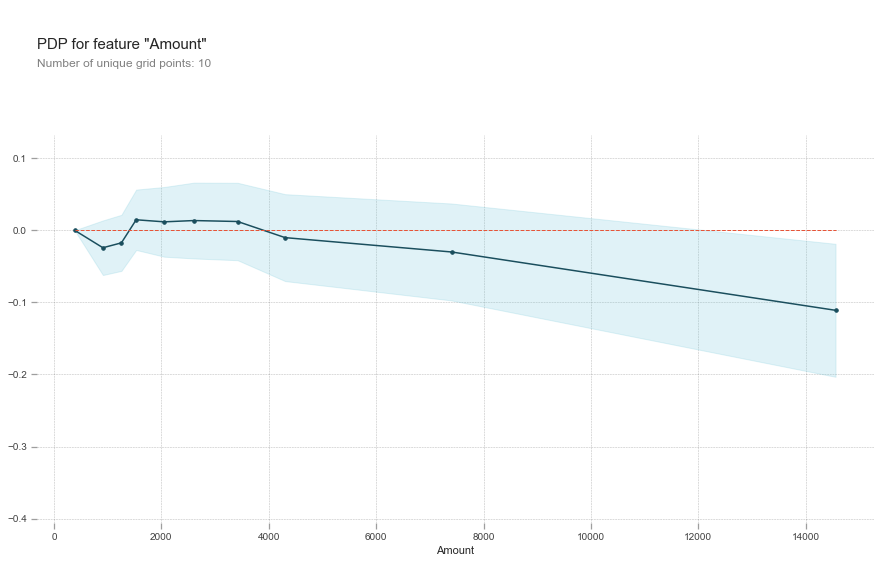

In [40]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=clf, dataset=Xtest, model_features=Xtest.columns.tolist(), feature='Amount')
# plot it
pdp.pdp_plot(pdp_goals, 'Amount')
plt.show()

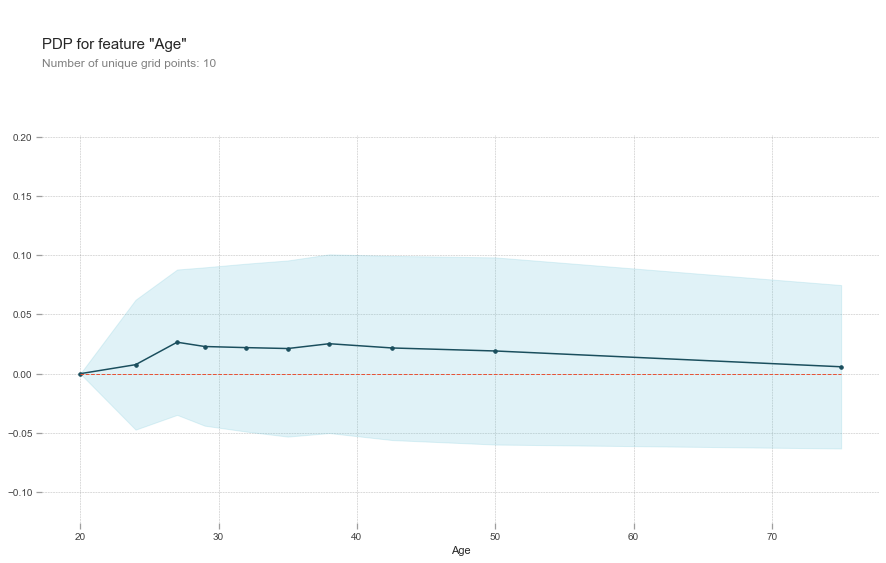

In [41]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=clf, dataset=Xtest, model_features=Xtest.columns.tolist(), feature='Age')
# plot it
pdp.pdp_plot(pdp_goals, 'Age')
plt.show()

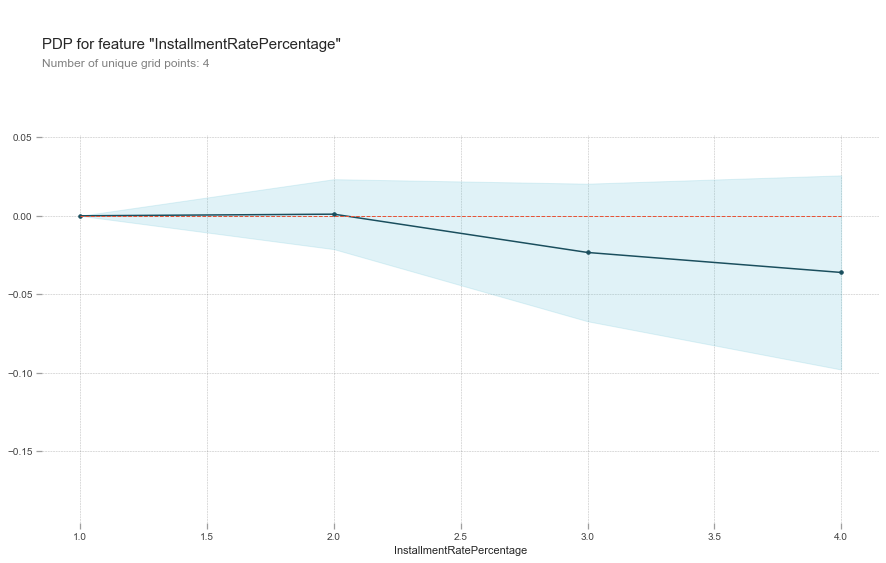

In [42]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=clf, dataset=Xtest, model_features=Xtest.columns.tolist(), feature='InstallmentRatePercentage')
# plot it
pdp.pdp_plot(pdp_goals, 'InstallmentRatePercentage')
plt.show()

## (Optional) Advanced Boosting-Based Algorithms

As explained in the video lectures, the next generation of algorithms after Random Forests (that use Bagging, a.k.a. Bootstrap Aggregation) were developed using Boosting, and the first one of these were Gradient Boosted Machines, which are implemented in scikit-learn (http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting).

Still, in recent years, a number of variations on GBMs have been developed by different research amd industry groups, all of them bringing improvements, both in speed, accuracy and functionality to the original Gradient Boosting algorithms.

In no order of preference, these are:
1. **XGBoost**: https://xgboost.readthedocs.io/en/latest/
2. **CatBoost**: https://tech.yandex.com/catboost/
3. **LightGBM**: https://lightgbm.readthedocs.io/en/latest/

If you're using the Anaconda distribution, these are all very easy to install:

Your task in this optional section of the mini project is to read the documentation of these three libraries, and apply all of them to the "German Credit" dataset, just like you did in the case of Decision Trees and Random Forests.

The final deliverable of this section should be a table (can be a pandas DataFrame) which shows the accuracy of all the five algorthms taught in this mini project in one place.

Happy modeling! :)

In [43]:
from xgboost import XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb 

In [87]:
xgb = XGBRFClassifier()
xgb.fit(Xtrain, ytrain)

[18:44:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=16,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [88]:
preds = xgb.predict(Xtest)

In [207]:
accuracy_scores['XGBoost'] = accuracy_score(preds, ytest)

print(classification_report(preds, ytest))

print(confusion_matrix(preds, ytest))


print(f"Mattews correlation coefficient: {matthews_corrcoef(ytest, preds)}")

              precision    recall  f1-score   support

           0       0.25      0.57      0.35        40
           1       0.92      0.73      0.82       260

    accuracy                           0.71       300
   macro avg       0.58      0.65      0.58       300
weighted avg       0.83      0.71      0.75       300

[[ 23  17]
 [ 69 191]]
Mattews correlation coefficient: 0.22825148981671575


In [193]:
import shap
import numpy as np

In [194]:
explainer = shap.TreeExplainer(xgb)

In [195]:
shap_values = explainer.shap_values(Xtrain)


In [196]:
Xtest

Duration  Amount  InstallmentRatePercentage  ResidenceDuration  Age  \
131        36    6887                          4                  3   29   
354        10     727                          4                  4   46   
982        21    2923                          1                  1   28   
476        39    2569                          4                  4   24   
491        27    8318                          2                  4   42   
..        ...     ...                        ...                ...  ...   
558        24    3552                          3                  4   27   
31         24    4020                          2                  2   27   
116        42    7174                          4                  3   30   
467        48    7238                          3                  3   32   
97         18    2622                          4                  4   34   

     NumberExistingCredits  NumberPeopleMaintenance  Telephone  ForeignWorker  \
131                      1                        1          0              1   
354                      1                        1          0              1   
982                      1                        1          0              1   
476                      1                        1          1              1   
491                      2                        1          0              1   
..                     ...                      ...        ...            ...   
558                      1                        1          1              1   
31                       1                        1          1              1   
116                      1                        1          0              1   
467                      2                        2          1              1   
97                       1                        1          1              1   

     CheckingAccountStatus.lt.0  ...  OtherInstallmentPlans.Bank  \
131                           1  ...                           0   
354                           0  ...                           0   
982                           0  ...                           1   
476                           0  ...                           0   
491                           0  ...                           0   
..                          ...  ...                         ...   
558                           1  ...                           1   
31                            1  ...                           0   
116                           1  ...                           0   
467                           0  ...                           1   
97                            0  ...                           0   

     OtherInstallmentPlans.Stores  OtherInstallmentPlans.None  Housing.Rent  \
131                             1                           0             0   
354                             0                           1             0   
982                             0                           0             0   
476                             0                           1             0   
491                             0                           1             0   
..                            ...                         ...           ...   
558                             0                           0             0   
31                              1                           0             0   
116                             0                           1             0   
467                             0                           0             0   
97                              0                           1             0   

     Housing.Own  Housing.ForFree  Job.UnemployedUnskilled  \
131            1                0                        0   
354            0                1                        0   
982            1                0                        0   
476            1                0                        0   
491            0                1          

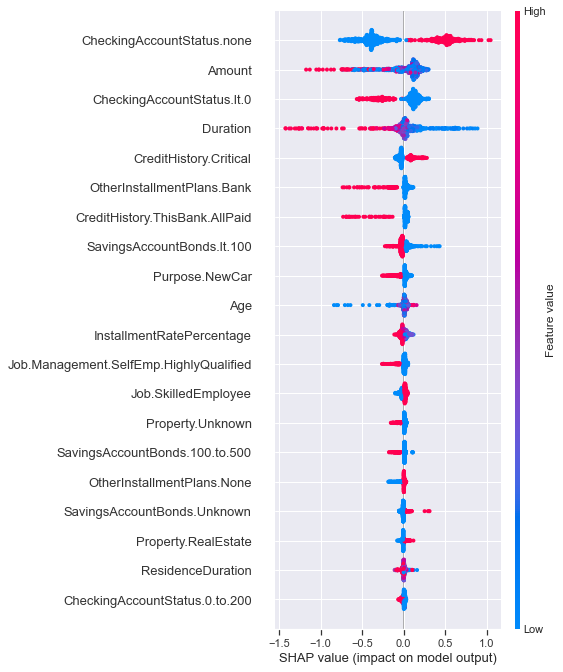

In [197]:
shap.summary_plot(shap_values, Xtrain)

In [198]:
model = CatBoostClassifier(learning_rate=0.2)
model.fit(Xtrain, ytrain)

results = model.predict(Xtest)

0:	learn: 0.6113054	total: 1.95ms	remaining: 1.95s
1:	learn: 0.5496196	total: 4.07ms	remaining: 2.03s
2:	learn: 0.5166485	total: 5.91ms	remaining: 1.96s
3:	learn: 0.4837034	total: 7.56ms	remaining: 1.88s
4:	learn: 0.4621950	total: 9.25ms	remaining: 1.84s
5:	learn: 0.4423782	total: 29.8ms	remaining: 4.93s
6:	learn: 0.4216002	total: 44.9ms	remaining: 6.37s
7:	learn: 0.4086705	total: 46.6ms	remaining: 5.78s
8:	learn: 0.3947427	total: 48.5ms	remaining: 5.34s
9:	learn: 0.3870538	total: 51ms	remaining: 5.05s
10:	learn: 0.3754631	total: 52.7ms	remaining: 4.74s
11:	learn: 0.3679667	total: 54.4ms	remaining: 4.48s
12:	learn: 0.3574941	total: 56.1ms	remaining: 4.26s
13:	learn: 0.3507549	total: 57.7ms	remaining: 4.06s
14:	learn: 0.3439705	total: 59.9ms	remaining: 3.93s
15:	learn: 0.3365561	total: 61.5ms	remaining: 3.78s
16:	learn: 0.3235958	total: 63.2ms	remaining: 3.65s
17:	learn: 0.3171210	total: 64.9ms	remaining: 3.54s
18:	learn: 0.3116246	total: 66.6ms	remaining: 3.44s
19:	learn: 0.3033433	tot

257:	learn: 0.0145328	total: 529ms	remaining: 1.52s
258:	learn: 0.0145035	total: 531ms	remaining: 1.52s
259:	learn: 0.0144200	total: 533ms	remaining: 1.52s
260:	learn: 0.0143184	total: 534ms	remaining: 1.51s
261:	learn: 0.0142731	total: 536ms	remaining: 1.51s
262:	learn: 0.0140621	total: 538ms	remaining: 1.51s
263:	learn: 0.0139756	total: 539ms	remaining: 1.5s
264:	learn: 0.0138954	total: 541ms	remaining: 1.5s
265:	learn: 0.0138953	total: 542ms	remaining: 1.5s
266:	learn: 0.0137763	total: 544ms	remaining: 1.49s
267:	learn: 0.0136791	total: 546ms	remaining: 1.49s
268:	learn: 0.0135733	total: 547ms	remaining: 1.49s
269:	learn: 0.0134830	total: 549ms	remaining: 1.48s
270:	learn: 0.0134159	total: 551ms	remaining: 1.48s
271:	learn: 0.0133629	total: 552ms	remaining: 1.48s
272:	learn: 0.0132727	total: 554ms	remaining: 1.47s
273:	learn: 0.0131946	total: 555ms	remaining: 1.47s
274:	learn: 0.0130908	total: 557ms	remaining: 1.47s
275:	learn: 0.0130303	total: 558ms	remaining: 1.46s
276:	learn: 0.0

470:	learn: 0.0075075	total: 887ms	remaining: 996ms
471:	learn: 0.0074784	total: 888ms	remaining: 994ms
472:	learn: 0.0074784	total: 890ms	remaining: 992ms
473:	learn: 0.0074783	total: 892ms	remaining: 990ms
474:	learn: 0.0074783	total: 893ms	remaining: 987ms
475:	learn: 0.0074783	total: 895ms	remaining: 985ms
476:	learn: 0.0074383	total: 897ms	remaining: 983ms
477:	learn: 0.0074375	total: 898ms	remaining: 981ms
478:	learn: 0.0074375	total: 900ms	remaining: 979ms
479:	learn: 0.0074375	total: 902ms	remaining: 977ms
480:	learn: 0.0074374	total: 903ms	remaining: 975ms
481:	learn: 0.0074373	total: 905ms	remaining: 972ms
482:	learn: 0.0074373	total: 906ms	remaining: 970ms
483:	learn: 0.0074373	total: 908ms	remaining: 968ms
484:	learn: 0.0074372	total: 910ms	remaining: 966ms
485:	learn: 0.0074372	total: 911ms	remaining: 963ms
486:	learn: 0.0074371	total: 913ms	remaining: 962ms
487:	learn: 0.0074371	total: 914ms	remaining: 959ms
488:	learn: 0.0074223	total: 916ms	remaining: 957ms
489:	learn: 

643:	learn: 0.0061455	total: 1.25s	remaining: 689ms
644:	learn: 0.0061454	total: 1.25s	remaining: 687ms
645:	learn: 0.0061267	total: 1.25s	remaining: 684ms
646:	learn: 0.0061134	total: 1.25s	remaining: 682ms
647:	learn: 0.0061132	total: 1.25s	remaining: 680ms
648:	learn: 0.0060895	total: 1.25s	remaining: 678ms
649:	learn: 0.0060895	total: 1.25s	remaining: 676ms
650:	learn: 0.0060895	total: 1.26s	remaining: 674ms
651:	learn: 0.0060895	total: 1.26s	remaining: 672ms
652:	learn: 0.0060895	total: 1.26s	remaining: 670ms
653:	learn: 0.0060893	total: 1.26s	remaining: 668ms
654:	learn: 0.0060893	total: 1.26s	remaining: 666ms
655:	learn: 0.0060893	total: 1.26s	remaining: 664ms
656:	learn: 0.0060893	total: 1.27s	remaining: 662ms
657:	learn: 0.0060892	total: 1.27s	remaining: 660ms
658:	learn: 0.0060891	total: 1.27s	remaining: 658ms
659:	learn: 0.0060891	total: 1.27s	remaining: 656ms
660:	learn: 0.0060891	total: 1.27s	remaining: 653ms
661:	learn: 0.0060890	total: 1.27s	remaining: 651ms
662:	learn: 

850:	learn: 0.0055334	total: 1.63s	remaining: 285ms
851:	learn: 0.0055334	total: 1.63s	remaining: 283ms
852:	learn: 0.0055334	total: 1.63s	remaining: 281ms
853:	learn: 0.0055333	total: 1.63s	remaining: 279ms
854:	learn: 0.0055333	total: 1.63s	remaining: 277ms
855:	learn: 0.0055333	total: 1.63s	remaining: 275ms
856:	learn: 0.0055004	total: 1.64s	remaining: 273ms
857:	learn: 0.0055004	total: 1.64s	remaining: 271ms
858:	learn: 0.0055004	total: 1.64s	remaining: 269ms
859:	learn: 0.0055004	total: 1.64s	remaining: 267ms
860:	learn: 0.0054769	total: 1.64s	remaining: 265ms
861:	learn: 0.0054665	total: 1.64s	remaining: 263ms
862:	learn: 0.0054414	total: 1.65s	remaining: 261ms
863:	learn: 0.0054262	total: 1.65s	remaining: 259ms
864:	learn: 0.0053968	total: 1.65s	remaining: 257ms
865:	learn: 0.0053968	total: 1.65s	remaining: 255ms
866:	learn: 0.0053968	total: 1.65s	remaining: 253ms
867:	learn: 0.0053967	total: 1.65s	remaining: 251ms
868:	learn: 0.0053967	total: 1.66s	remaining: 250ms
869:	learn: 

In [209]:
print(classification_report(results, ytest))

print(confusion_matrix(results, ytest))

print(f"Mattews correlation coefficient: {matthews_corrcoef(ytest, results)}")

              precision    recall  f1-score   support

           0       0.41      0.63      0.50        60
           1       0.89      0.78      0.83       240

    accuracy                           0.75       300
   macro avg       0.65      0.70      0.67       300
weighted avg       0.80      0.75      0.76       300

[[ 38  22]
 [ 54 186]]
Mattews correlation coefficient: 0.3542178958293221


In [200]:
explainer = shap.TreeExplainer(model)

In [201]:
shap_values = explainer.shap_values(Xtrain)

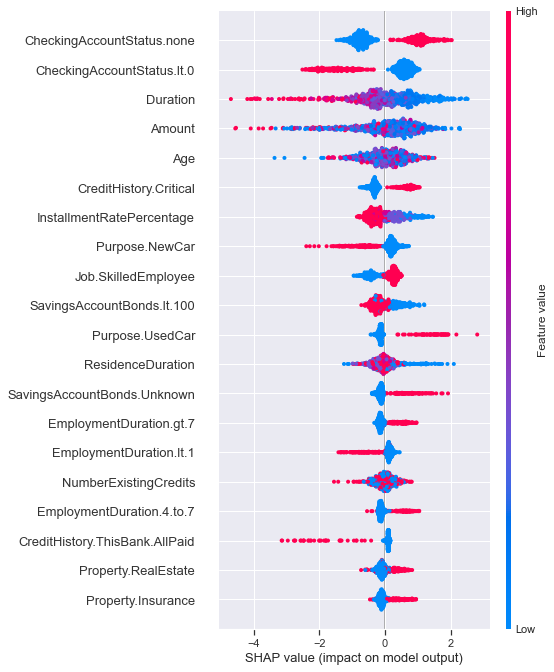

In [202]:
shap.summary_plot(shap_values, Xtrain)

In [175]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5,:], Xtrain.iloc[5,:])

In [176]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], Xtrain.iloc[0,:])

In [208]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10,:], Xtrain.iloc[10,:])

In [177]:
accuracy_scores['CatBoost'] = model.score(Xtest, ytest)

In [230]:
lgbm = LGBMClassifier(boosting_type="gbdt",
                         n_estimators=50,
                         min_child_weight=5,
                         subsample=.632, # Standard RF bagging fraction
                         subsample_freq=1,
                         min_split_gain=0,
                         reg_alpha=0.1, # Hard L1 regularization
                         reg_lambda=0,
                         objective='binary')

pars = {'objective': 'logistic'}

# train_data = lgb.Dataset(Xtrain, ytrain)
# valid_data = lgb.Dataset(Xtest, ytest)

lgbm.fit(Xtrain, ytrain)
preds = lgbm.predict(Xtest)

In [235]:
print(classification_report(preds, ytest))

print(confusion_matrix(preds, ytest))
print(f"Mattews correlation coefficient: {matthews_corrcoef(ytest, preds)}")

              precision    recall  f1-score   support

           0       0.38      0.62      0.47        56
           1       0.90      0.77      0.83       244

    accuracy                           0.74       300
   macro avg       0.64      0.70      0.65       300
weighted avg       0.80      0.74      0.76       300

[[ 35  21]
 [ 57 187]]
Mattews correlation coefficient: 0.33073251298860884


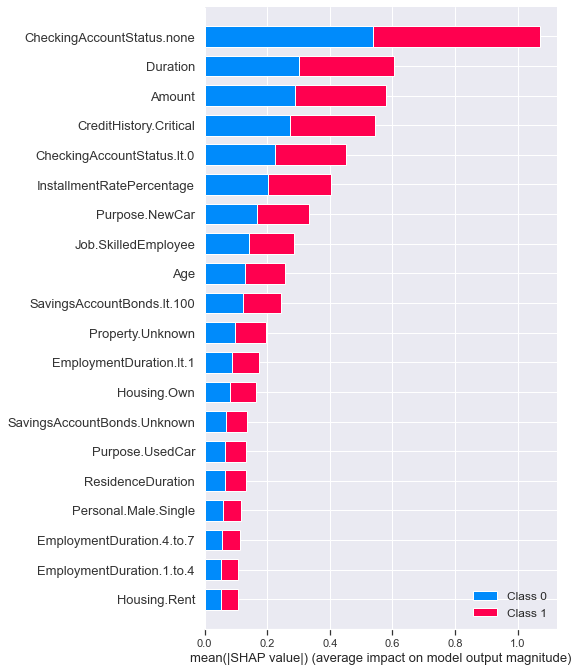

In [241]:
explainer = shap.TreeExplainer(lgbm)

shap_values = explainer.shap_values(Xtrain)

shap.summary_plot(shap_values, Xtrain)

In [242]:
accuracy_scores['LGBM'] = accuracy_score(preds, ytest)

In [243]:
accuracy_scores

{'DescionTreeClassifier': 0.72,
 'RandomTreeClassifier': 0.7,
 'XGBoost': 0.7133333333333334,
 'CatBoost': 0.7466666666666667,
 'LGBM': 0.74}

#### From the accuracy scores, cat boost clearly had the best accuracy scores.  By also looking at the Matthews correlation coefficient which is better metric for imbalanced classes, it also supports that catboost is the best classifer in this case.  